Documentación pyedflib: https://pyedflib.readthedocs.io/en/latest/ref/edfreader.html  
Documentación networkx: https://networkx.org/documentation/stable/reference/introduction.html  
Información grafos: https://www.cienciadedatos.net/documentos/pygml01-introduccion-grafos-redes-python.html  
Información mne: https://mne.tools/stable/index.html  

In [40]:
import mne
import pyedflib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from os.path import basename
from pprint import pprint
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap

CHANNELS: tuple[str] = ('Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 
                        'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 
                        'Fz', 'Cz', 'Pz')
N_CHANNELS: int = len(CHANNELS)

df_subject_info = pd.read_csv('Archivos\subject-info.csv')[['Subject', 'Count quality']]

# Posición aproximada de los electrodos en la cabeza
pos = {
    'Fp1': (-0.300, 0.954), 'Fp2': (0.300, 0.954),
    'F3': (-0.400, 0.510), 'F4': (0.400, 0.510),
    'F7': (-0.800, 0.600), 'F8': (0.800, 0.600),
    'T3': (-1.000, 0.000), 'T4': (1.000, 0.000),
    'C3': (-0.500, 0.000), 'C4': (0.500, 0.000),
    'T5': (-0.800, -0.600), 'T6': (0.800, -0.600),
    'P3': (-0.400, -0.510), 'P4': (0.400, -0.510),
    'O1': (-0.300, -0.954), 'O2': (0.300, -0.954),
    'Fz': (0.000, 0.500), 'Cz': (0.000, 0.000),
    'Pz': (0.000, -0.500)
}

In [3]:
# Convertir un archivo EDF a CSV

def edf_to_csv(filename: str, output_path: str = '') -> None:
    # Se guardan los archivos en una matriz 19 x No. Señales (31000 o 91000)

    f: pyedflib.EdfReader = pyedflib.EdfReader(filename)
    
    signals: np.zeros = np.zeros((N_CHANNELS + 1, m := f.getNSamples()[0]))
    signals[0, :] = np.arange(1, m + 1) # Es la cabecera de las columnas que son numeros desde el 1 al No. Señales
    for i in np.arange(1, N_CHANNELS + 1):
        signals[i, :]= f.readSignal(i - 1)

    np.savetxt(output_path + basename(filename.replace('.edf', '.csv')), signals, delimiter=';')

    f.close()

In [4]:
# Funciones a partir de la ruta

def get_distances(path: str) -> pd.DataFrame:
    df: pd.DataFrame = pd.read_csv(path, sep=';')

    df = np.transpose(df)
    df.columns=CHANNELS

    # Hacer la matriz de correlación
    df_correlation: pd.DataFrame = df.corr()

    # Obtener las listas de las distancias a partir de las correlaciones
    # Dij = sqrt(2 * (1 - Cij))
    df_distances: pd.DataFrame = pd.DataFrame(np.sqrt(2 * (1 - df_correlation)), index=CHANNELS, columns=CHANNELS)

    return df_distances

def get_graph(path: str) -> nx.Graph:
    df_distances: pd.DataFrame = get_distances(path)

    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])

    return g0

def get_mst(path: str) -> nx.Graph:
    return nx.minimum_spanning_tree(get_graph(path))

def centrality(path: str) -> pd.DataFrame:
    mst_g0 = get_mst(path)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

In [5]:
# Funciones a partir de la matriz de distancias

def get_graph_from_df(df_distances: pd.DataFrame) -> nx.Graph:
    edges = df_distances.stack().reset_index()
    edges.columns = ["target", "source", "weight"]
    edges = edges.loc[edges["target"] != edges["source"]].copy()

    # Quitar las columnas repetidas
    edges['sorted_columns'] = np.sort(edges[['target', 'source']], axis=1).tolist()
    edges.drop_duplicates(subset='sorted_columns', keep='first', inplace=True)
    edges.drop('sorted_columns', axis=1, inplace=True)

    g0 = nx.from_pandas_edgelist(edges, "target", "source", edge_attr=["weight"])

    return g0

def get_mst_from_df(df_distances: pd.DataFrame) -> nx.Graph:
    return nx.minimum_spanning_tree(get_graph_from_df(df_distances))

def get_centrality_from_df(df_distances: pd.DataFrame) -> pd.DataFrame:
    mst_g0 = get_mst_from_df(df_distances)

    degree_centrality = nx.degree_centrality(mst_g0)
    betweenness_centrality = nx.betweenness_centrality(mst_g0)
    closeness_centrality = nx.closeness_centrality(mst_g0)
    pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

    return pd.DataFrame({
        'nodes': CHANNELS,
        'degree': degree_centrality.values(),
        'betweenness': betweenness_centrality.values(),
        'closeness': closeness_centrality.values(),
        'pagerank': pagerank.values()
    })

Text(0.5, 1.0, 'Ubicación electrodos - Sistema Internacional 1020')

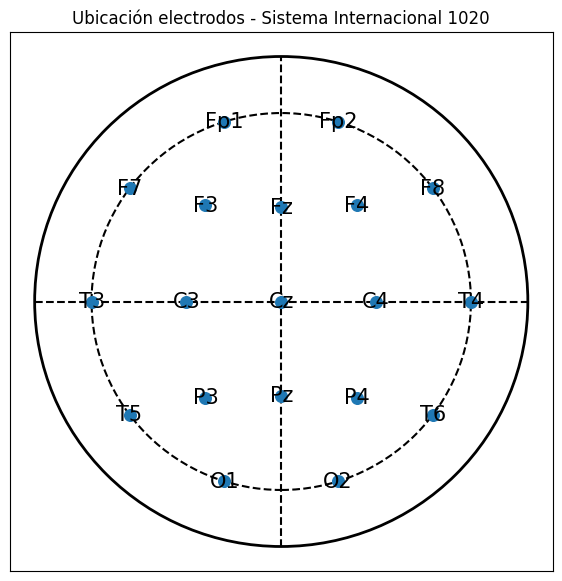

In [85]:
# Hacer una gráfica donde se vea la ubicación de los nodos (No es exacta - El montaje del sistema 1020)

fig, ax = plt.subplots(figsize=(7, 7))

ax.add_patch(Circle((0, 0), radius=1, color='black', fill=False, linestyle='--', linewidth=1.5))
ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=2))

# Agregar segmentos
ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='black', linewidth=1.5)
ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='black', linewidth=1.5)

G = nx.Graph()
G.add_nodes_from(CHANNELS)

nx.draw_networkx(
    G,
    pos,
    node_size=70,
    with_labels=True,
    font_size=15
)

ax.set_title('Ubicación electrodos - Sistema Internacional 1020')

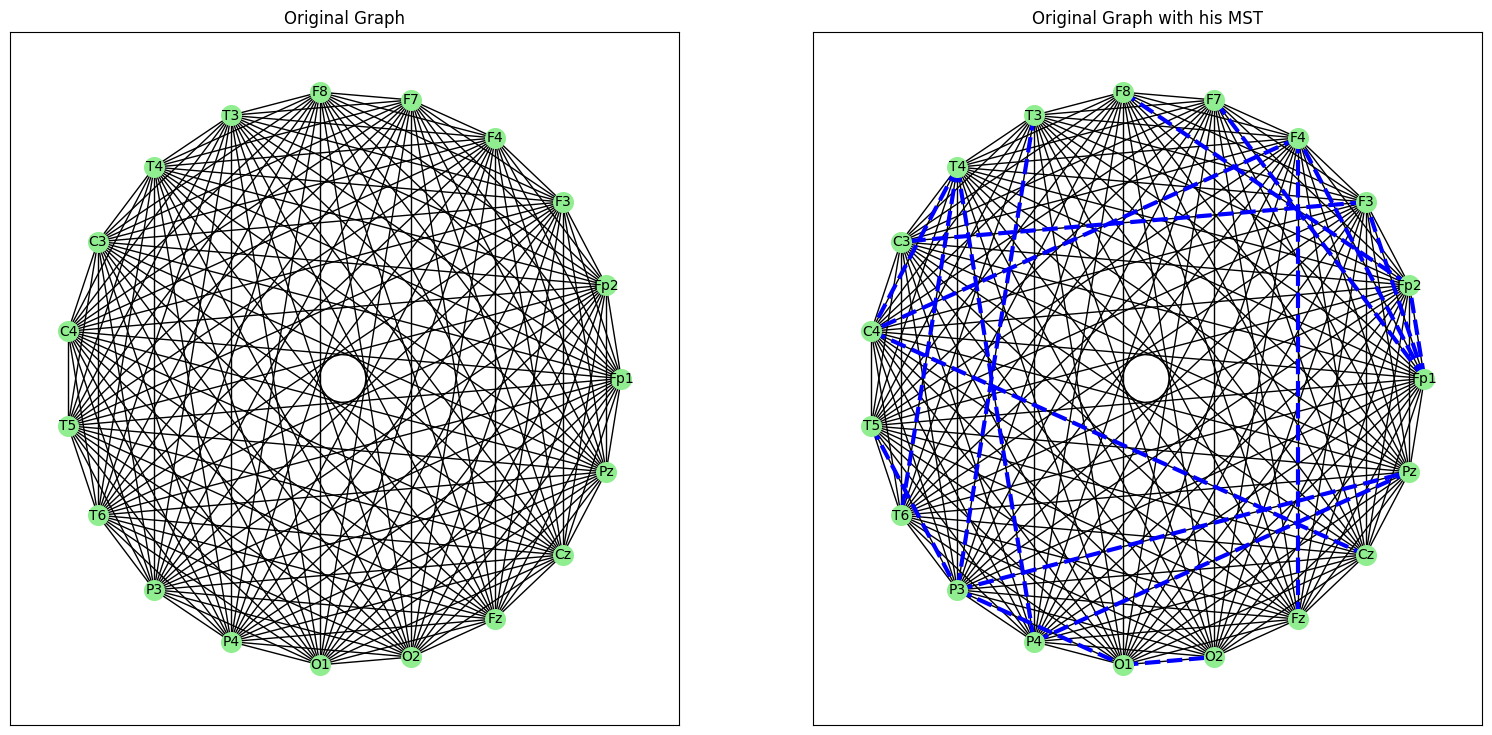

In [53]:
# mst sujeto00 antes

g0 = get_graph('Archivos\\Subject00\\csv\\Subject00_1.csv')
mst_g0 = nx.minimum_spanning_tree(g0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 9))

# Dibujar el grafo original
ax1.set_title('Original Graph')
nx.draw_networkx(
    g0, pos=nx.circular_layout(g0), with_labels=True, 
    node_size=200, node_color="lightgreen", 
    font_size=10, font_color="black",
    ax=ax1
)

# Dibujar la MST del grafo original
ax2.set_title("Original Graph with his MST")

nx.draw_networkx(
    g0, pos=nx.circular_layout(g0), with_labels=True, 
    node_size=200, node_color="lightgreen", 
    font_size=10, font_color="black",
    ax=ax2
)

# Dibujarle las lineas de las aristas
edges_mst = [(u, v) for u, v in mst_g0.edges]
nx.draw_networkx_edges(
    mst_g0, pos=nx.circular_layout(g0), edgelist=edges_mst,
    edge_color="blue", style="dashed", width=3,
    ax=ax2
)

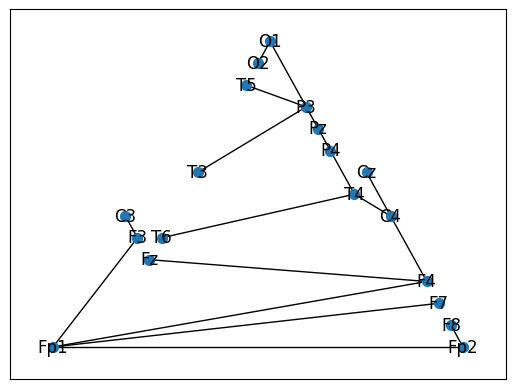

In [7]:
mst_g1 = get_mst('Archivos\\Subject00\\csv\\Subject00_1.csv')
nx.draw_networkx(
    mst_g1,
    nx.planar_layout(mst_g1),
    node_size=50
)

In [89]:
density = nx.density(mst_g0)
ave_clustering = nx.average_clustering(mst_g0)

print(f'Density: {density}')
print(f'Average clustering: {ave_clustering}\n')

degree_centrality = nx.degree_centrality(mst_g0)
print('Degree centrality:')
pprint(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

betweenness_centrality = nx.betweenness_centrality(mst_g0)
print('\nBetweness centrality')
pprint(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

closeness_centrality = nx.closeness_centrality(mst_g0)
print('\nClossenes centrality')
pprint(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

pagerank = nx.pagerank(mst_g0, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)
print('\nPagerank')
pprint(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

Density: 0.10526315789473684
Average clustering: 0.0

Degree centrality:
[('Fp1', 0.2222222222222222),
 ('P3', 0.2222222222222222),
 ('F4', 0.16666666666666666),
 ('T4', 0.16666666666666666),
 ('C4', 0.16666666666666666)]

Betweness centrality
[('C4', 0.5816993464052288),
 ('T4', 0.5686274509803921),
 ('F4', 0.542483660130719),
 ('Fp1', 0.477124183006536),
 ('P4', 0.47058823529411764)]

Clossenes centrality
[('C4', 0.32142857142857145),
 ('T4', 0.3157894736842105),
 ('F4', 0.3050847457627119),
 ('P4', 0.2903225806451613),
 ('Fp1', 0.2727272727272727)]

Pagerank
[('P3', 0.10972118843902842),
 ('Fp1', 0.09441549482198572),
 ('C4', 0.08446214111230474),
 ('T4', 0.07367667841667408),
 ('F4', 0.07143403418226048)]


In [90]:
# Datos para sacar los diagrama de barras para cada medida de centralidad
df_centrality = pd.DataFrame({
    'nodes': CHANNELS,
    'degree': degree_centrality.values(),
    'betweenness': betweenness_centrality.values(),
    'closeness': closeness_centrality.values(),
    'pagerank': pagerank.values()
})

df_centrality

nodes    degree  betweenness  closeness  pagerank
0    Fp1  0.222222     0.477124   0.272727  0.094415
1    Fp2  0.111111     0.111111   0.222222  0.053917
2     F3  0.111111     0.111111   0.222222  0.054822
3     F4  0.166667     0.542484   0.305085  0.071434
4     F7  0.055556     0.000000   0.216867  0.040555
5     F8  0.055556     0.000000   0.183673  0.037525
6     T3  0.055556     0.000000   0.189474  0.038682
7     T4  0.166667     0.568627   0.315789  0.073677
8     C3  0.055556     0.000000   0.183673  0.038422
9     C4  0.166667     0.581699   0.321429  0.084462
10    T5  0.055556     0.000000   0.189474  0.032426
11    T6  0.055556     0.000000   0.243243  0.028409
12    P3  0.222222     0.398693   0.230769  0.109721
13    P4  0.111111     0.470588   0.290323  0.049739
14    O1  0.111111     0.111111   0.193548  0.058629
15    O2  0.055556     0.000000   0.163636  0.034226
16    Fz  0.055556     0.000000   0.236842  0.020942
17    Cz  0.055556     0.000000   0.246575  0.033943
18    Pz  0.111111     0.424837   0.260870  0.044052

In [144]:
# Guarda las medidas de centralidad de los sujetos (antes y despues) en archivos

df_before = pd.DataFrame()
df_during = pd.DataFrame()

for i in range(0, 35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    df_temp1 = pd.DataFrame({'subject': [subject]*19})
    df_temp1 = pd.concat([df_temp1, centrality(csv_path1)], axis=1)
    df_temp1['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_before = pd.concat([df_before, df_temp1], ignore_index=True)

    df_temp2 = pd.DataFrame({'subject': [subject]*19})
    df_temp2 = pd.concat([df_temp2, centrality(csv_path2)], axis=1)
    df_temp2['count_quality'] = ('G' if df_subject_info["Count quality"][i] == 1 else 'B')
    df_during = pd.concat([df_during, df_temp2], ignore_index=True)

df_before.to_csv('Archivos\centrality_before.csv', sep=';', index=False)
df_during.to_csv('Archivos\centrality_during.csv', sep=';', index=False)

In [145]:
df_before = pd.read_csv('Archivos\centrality_before.csv', delimiter=';')
df_before['state'] = 'before'

df_during = pd.read_csv('Archivos\centrality_during.csv', delimiter=';')
df_during['state'] = 'during'

df_result = pd.concat([df_before, df_during], ignore_index=True)
df_result

subject nodes    degree  betweenness  closeness  pagerank  \
0     Subject00   Fp1  0.222222     0.477124   0.272727  0.094415   
1     Subject00   Fp2  0.111111     0.111111   0.222222  0.053917   
2     Subject00    F3  0.111111     0.111111   0.222222  0.054822   
3     Subject00    F4  0.166667     0.542484   0.305085  0.071434   
4     Subject00    F7  0.055556     0.000000   0.216867  0.040555   
...         ...   ...       ...          ...        ...       ...   
1363  Subject35    O1  0.111111     0.366013   0.240000  0.047850   
1364  Subject35    O2  0.111111     0.294118   0.209302  0.046602   
1365  Subject35    Fz  0.222222     0.398693   0.240000  0.094460   
1366  Subject35    Cz  0.111111     0.529412   0.300000  0.040156   
1367  Subject35    Pz  0.055556     0.000000   0.155172  0.027817   

     count_quality   state  
0                B  before  
1                B  before  
2                B  before  
3                B  before  
4                B  before  
...            ...     ...  
1363             G  during  
1364             G  during  
1365             G  during  
1366             G  during  
1367             G  during  

[1368 rows x 8 columns]

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

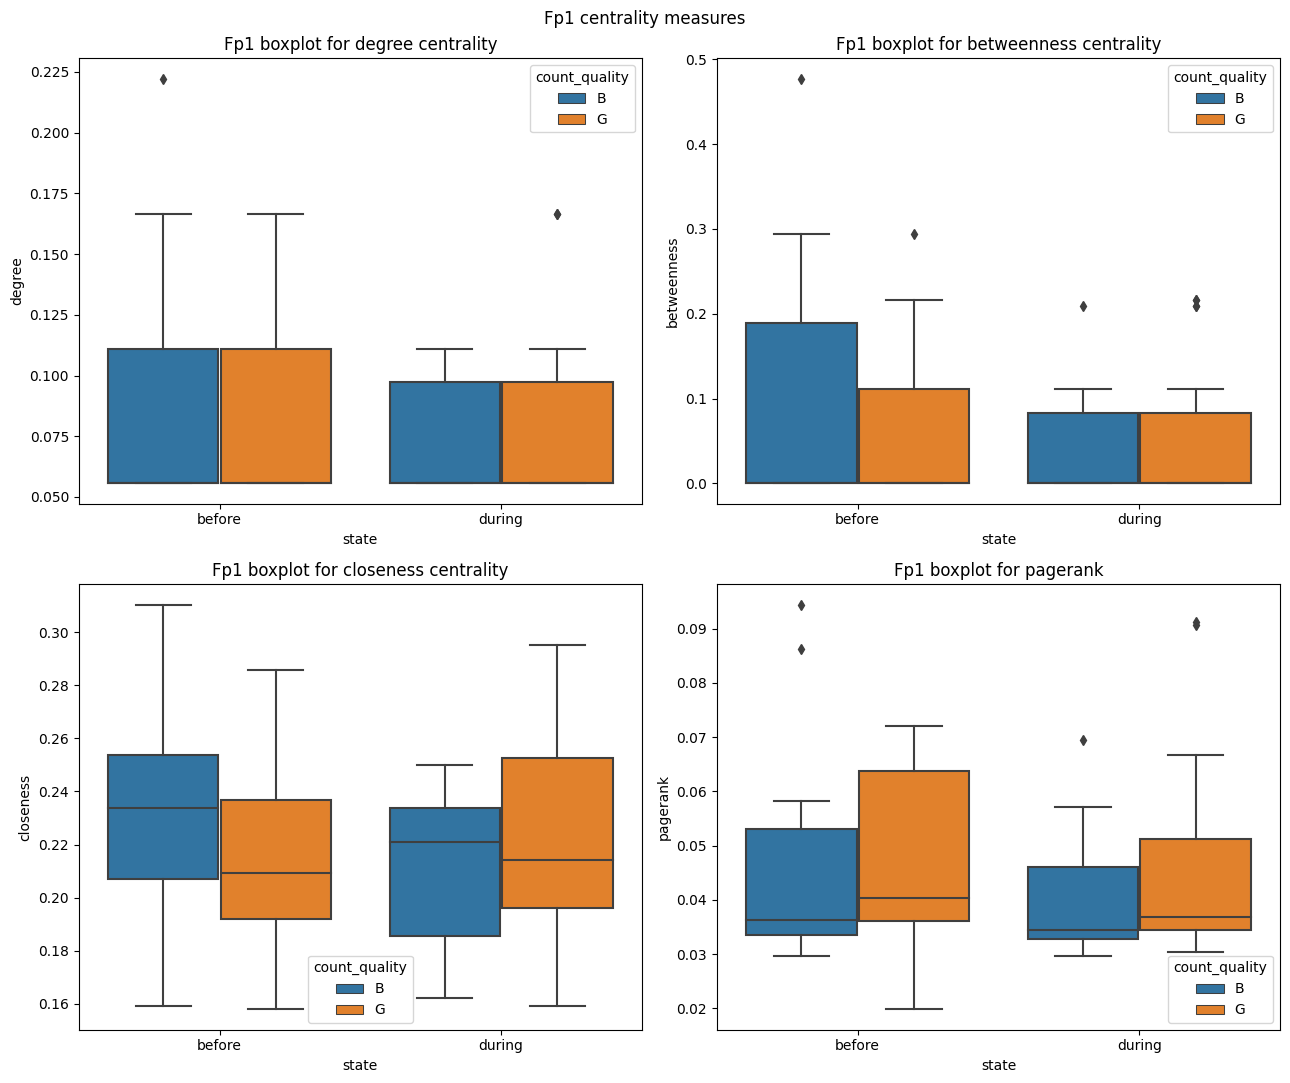

In [146]:
# Todas las gráficas de Fp1 para cada métrica diferente
sensor: str = 'Fp1'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

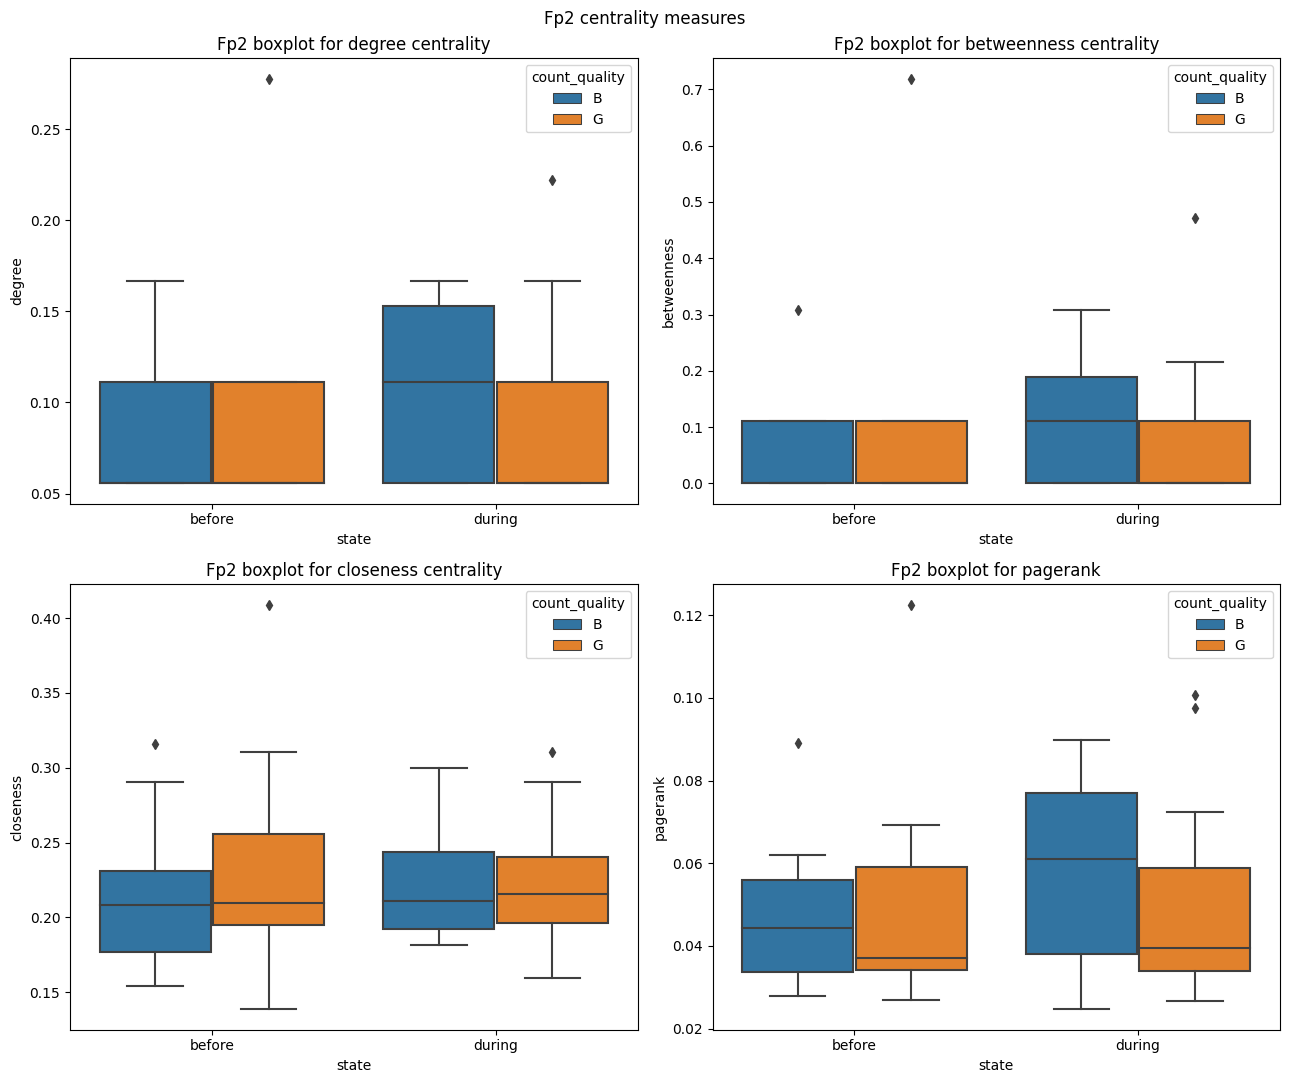

In [147]:
# Todas las gráficas de Fp2 para cada métrica diferente
sensor: str = 'Fp2'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

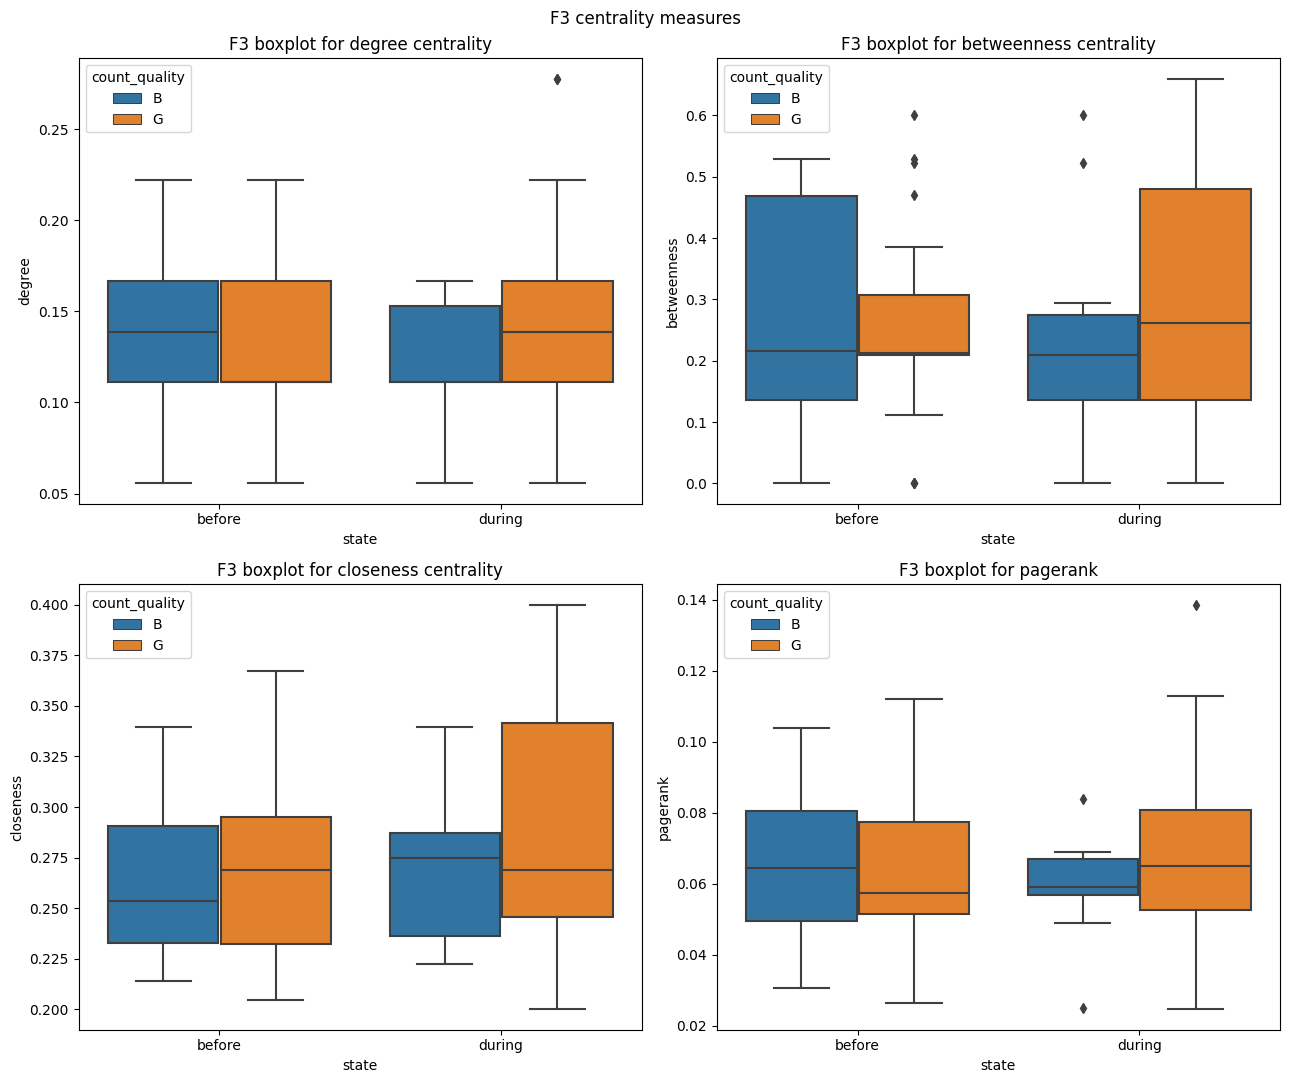

In [148]:
# Todas las gráficas de F3 para cada métrica diferente
sensor: str = 'F3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

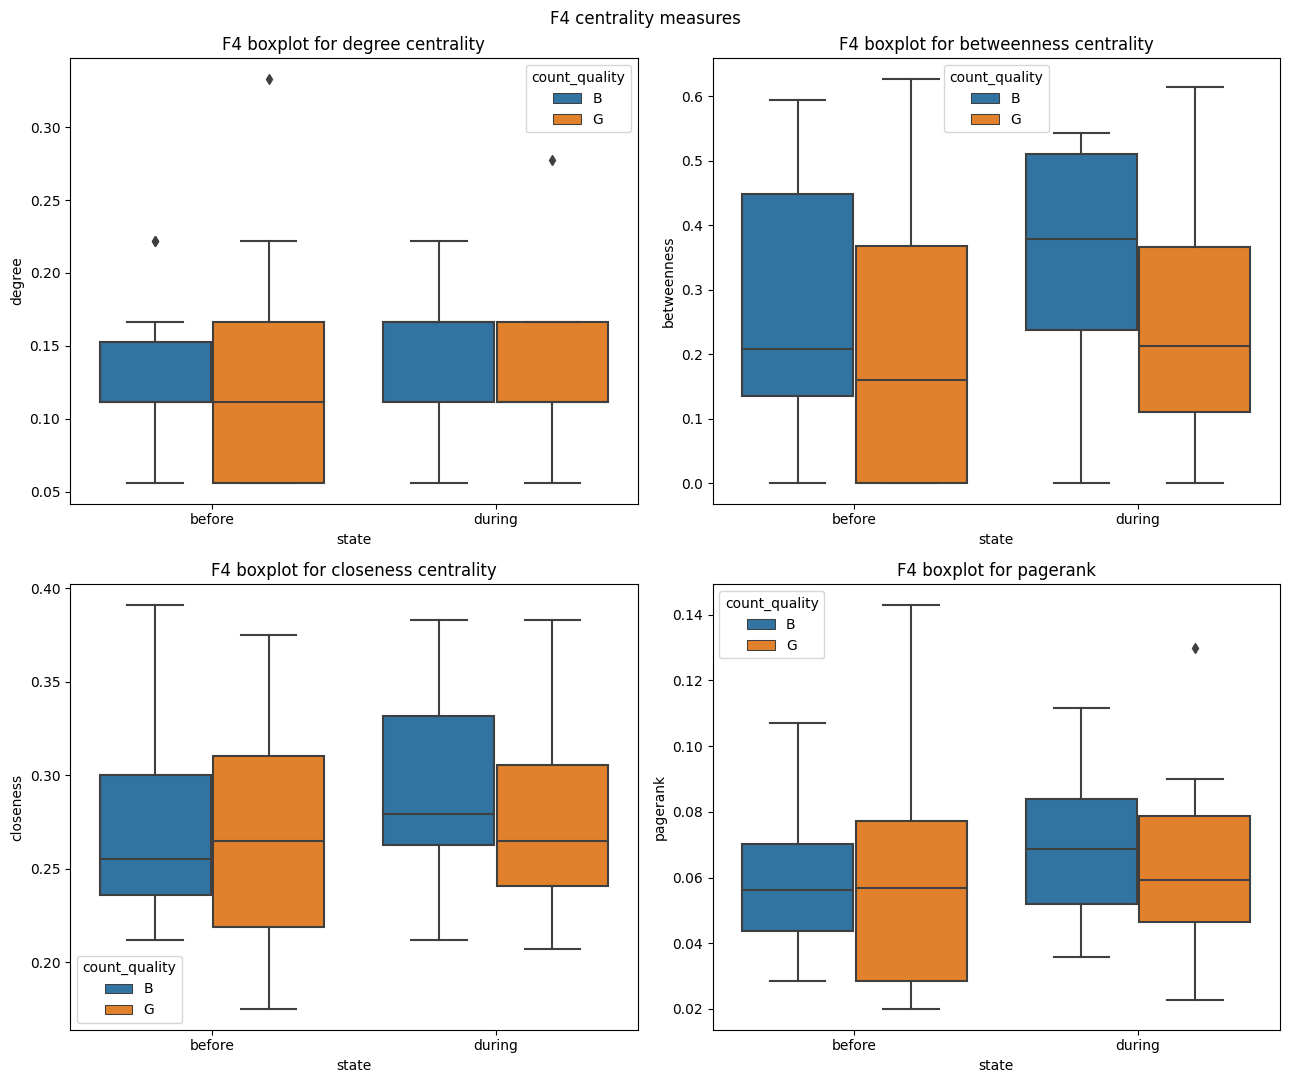

In [149]:
# Todas las gráficas de F4 para cada métrica diferente
sensor: str = 'F4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

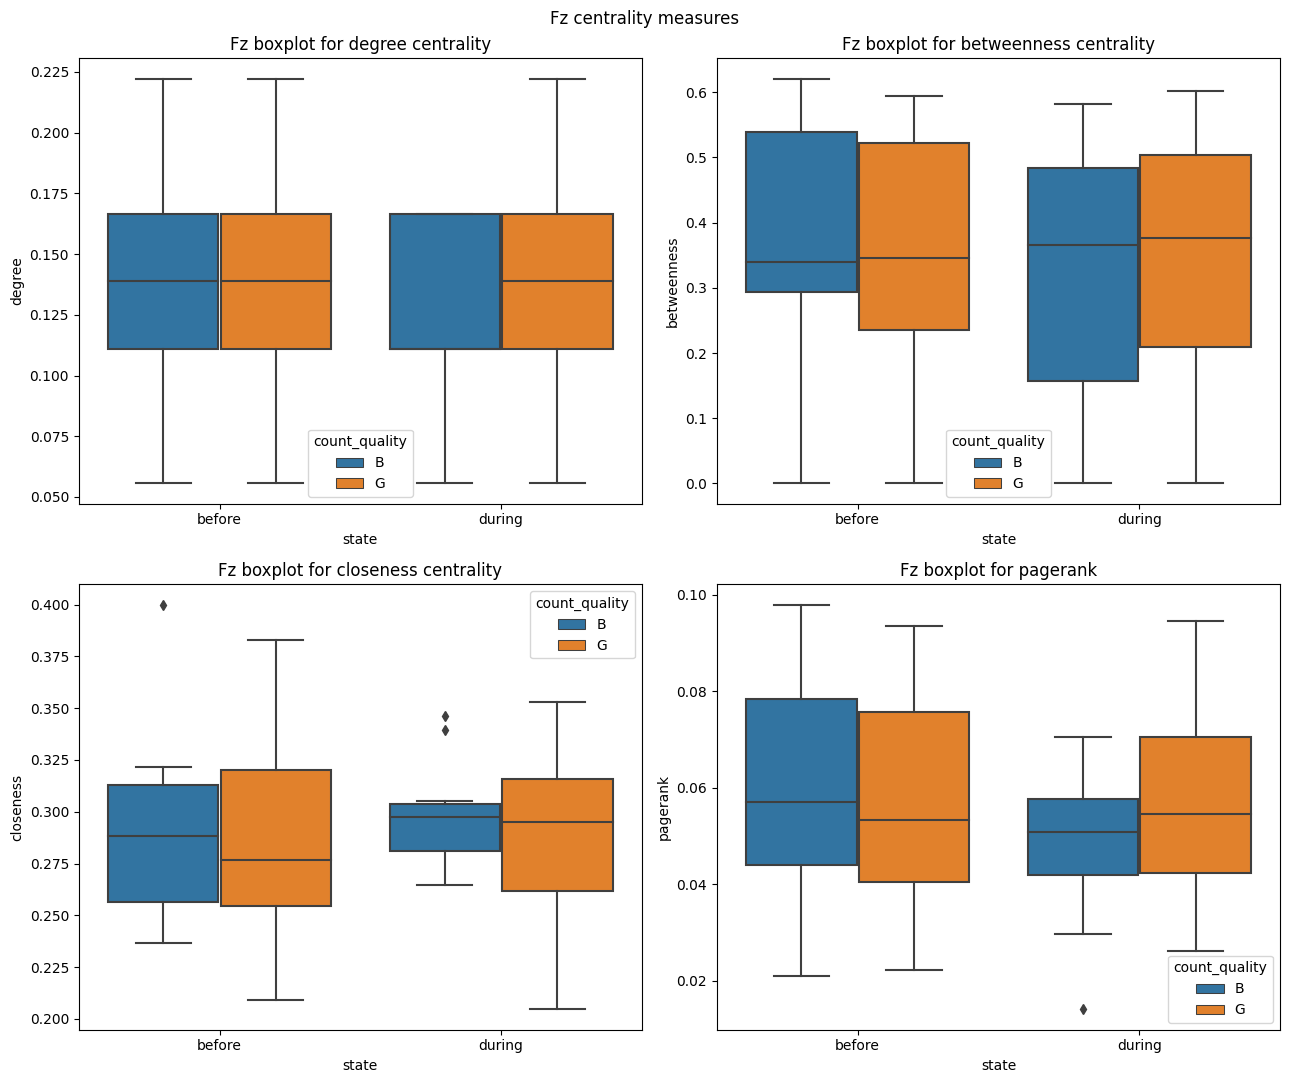

In [150]:
# Todas las gráficas de Fz para cada métrica diferente
sensor: str = 'Fz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

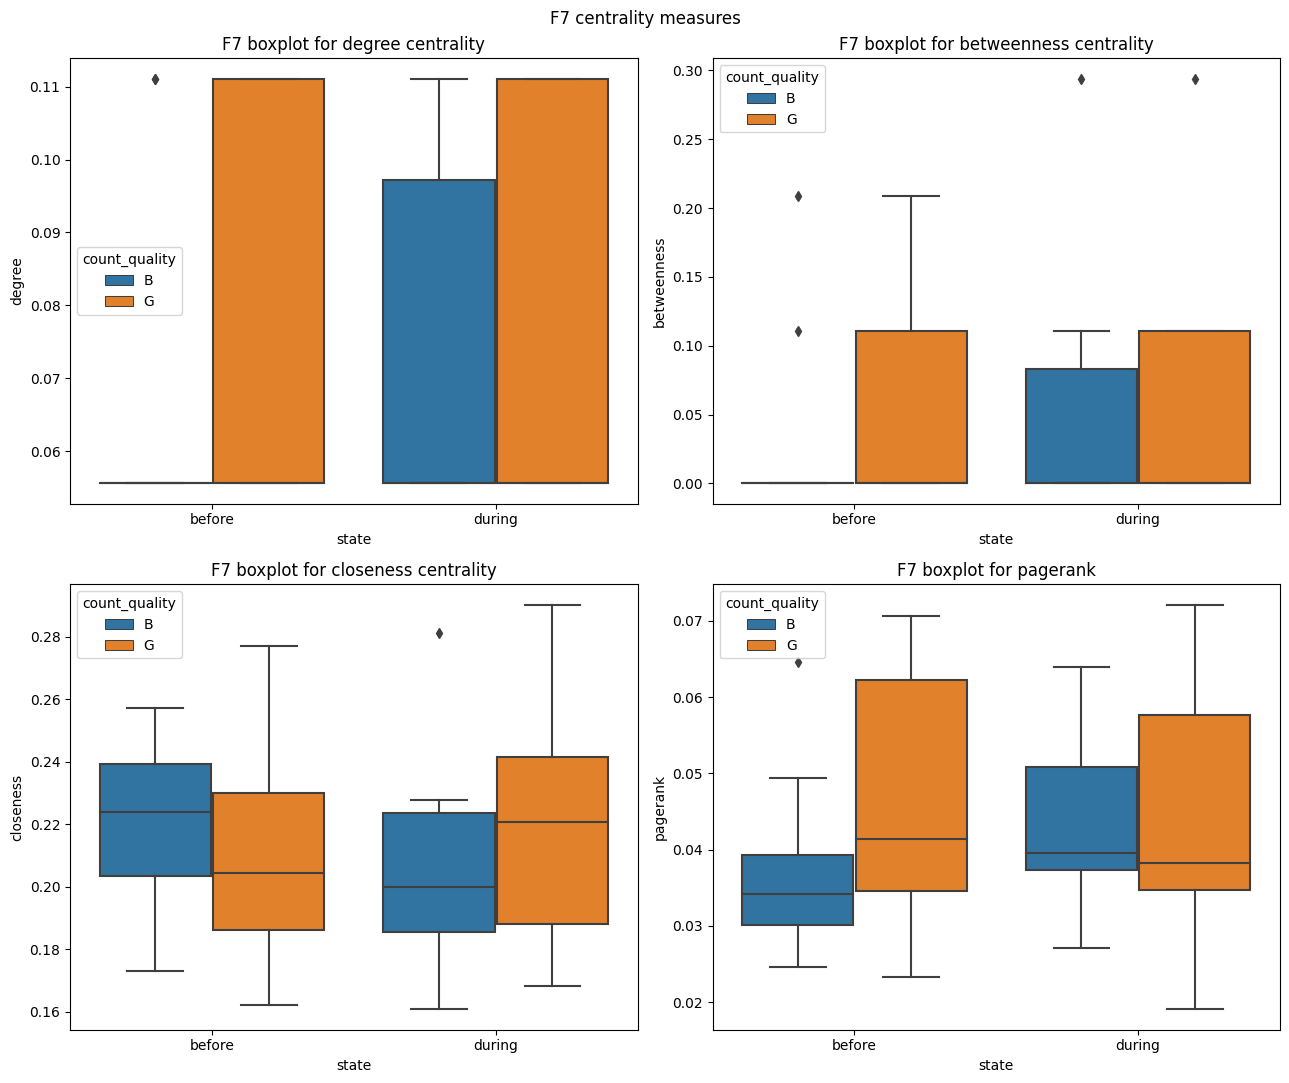

In [151]:
# Todas las gráficas de F7 para cada métrica diferente
sensor: str = 'F7'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

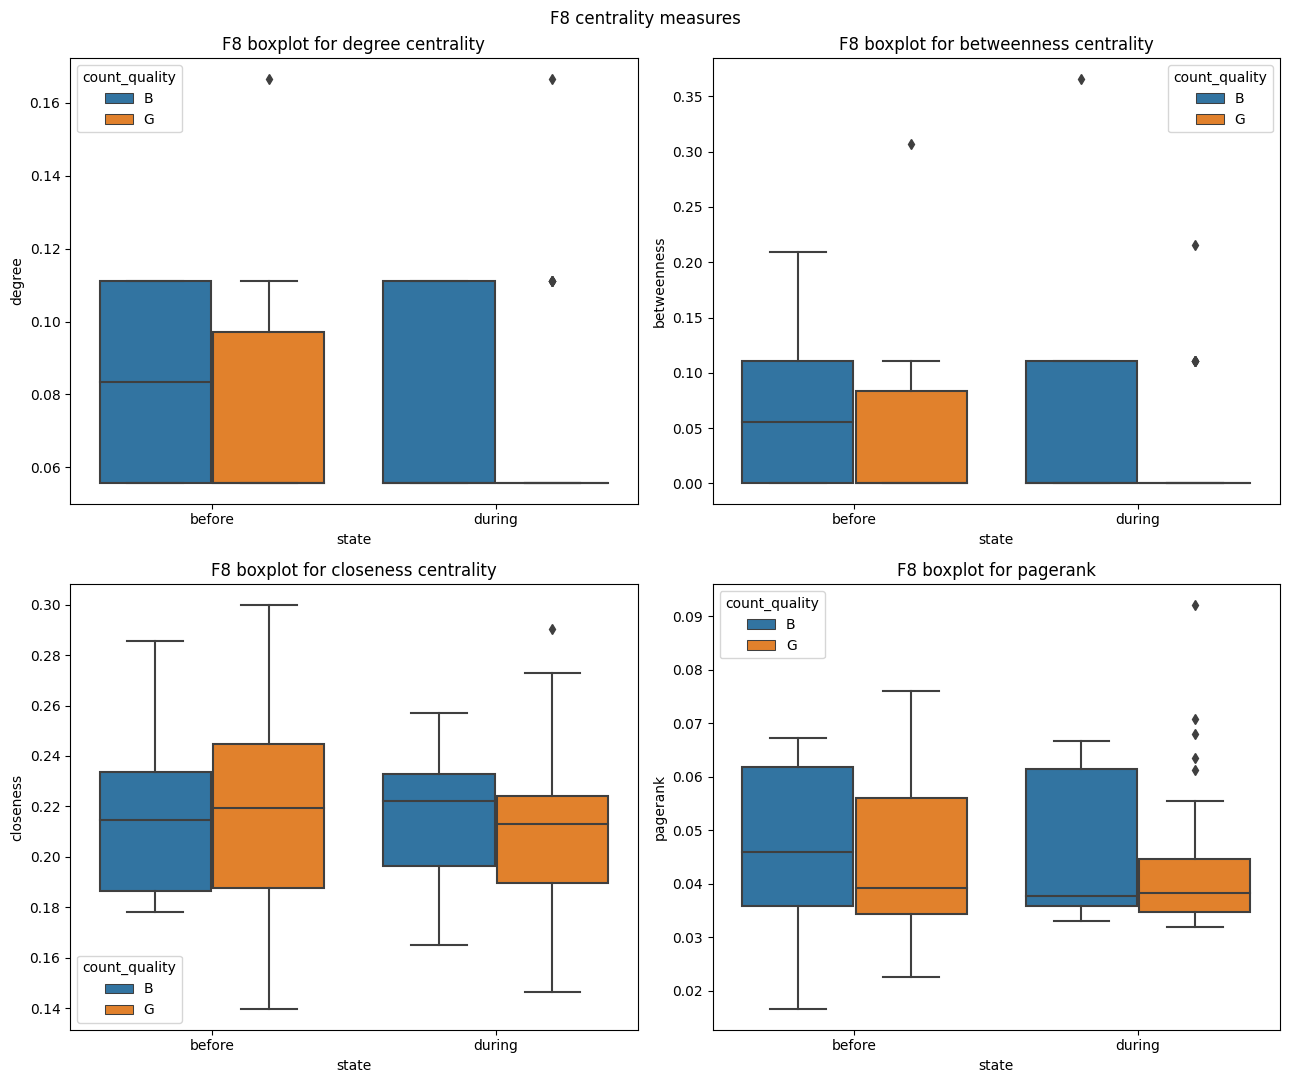

In [152]:
# Todas las gráficas de F8 para cada métrica diferente
sensor: str = 'F8'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

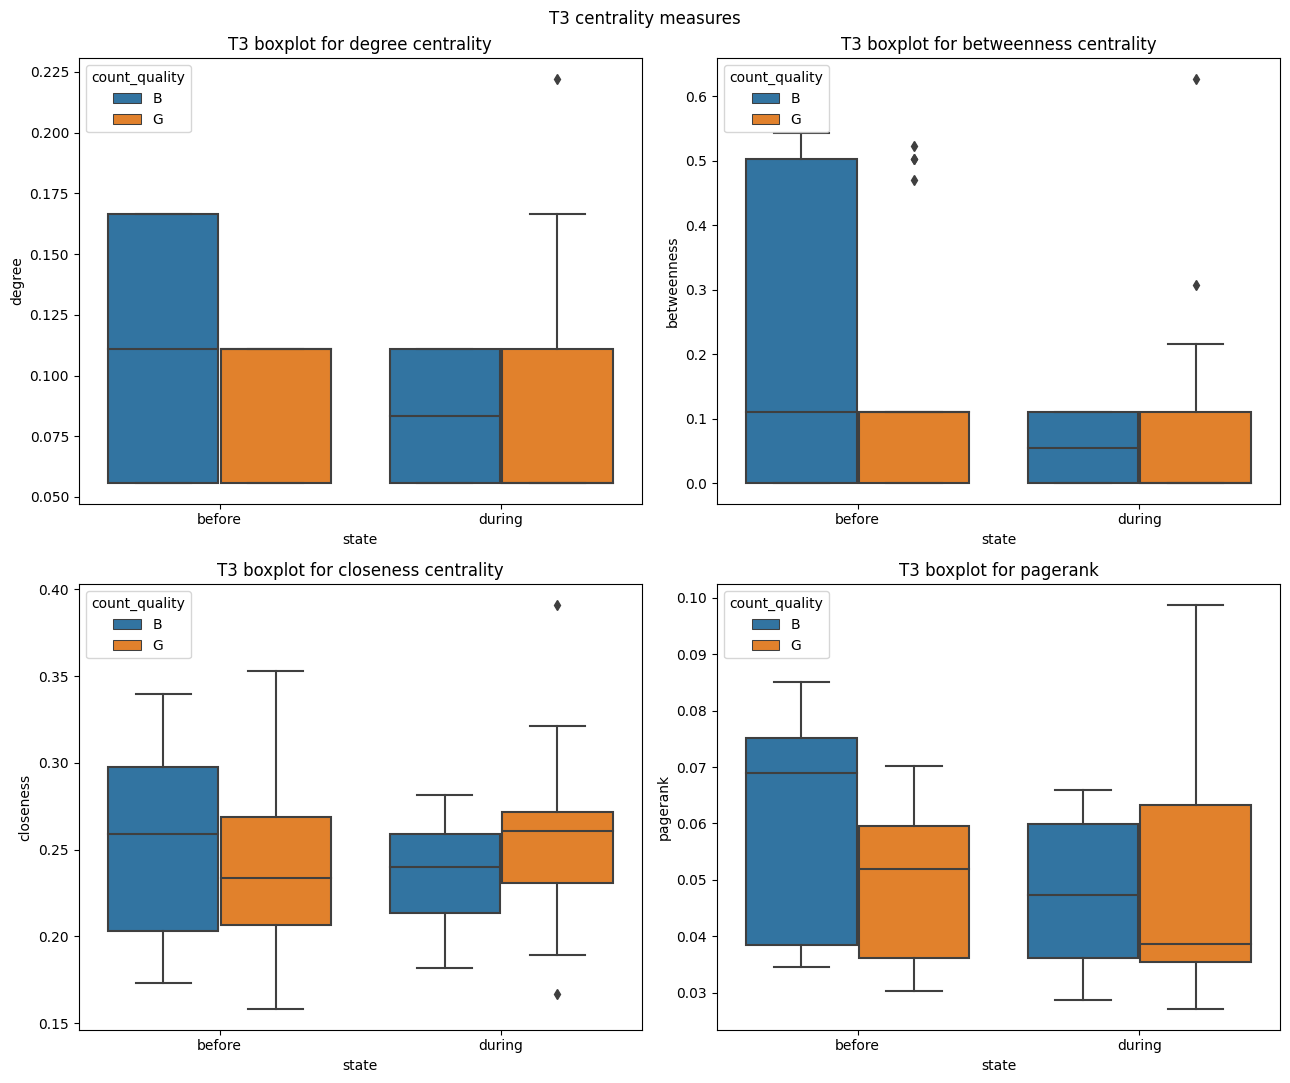

In [153]:
# Todas las gráficas de T3 para cada métrica diferente
sensor: str = 'T3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

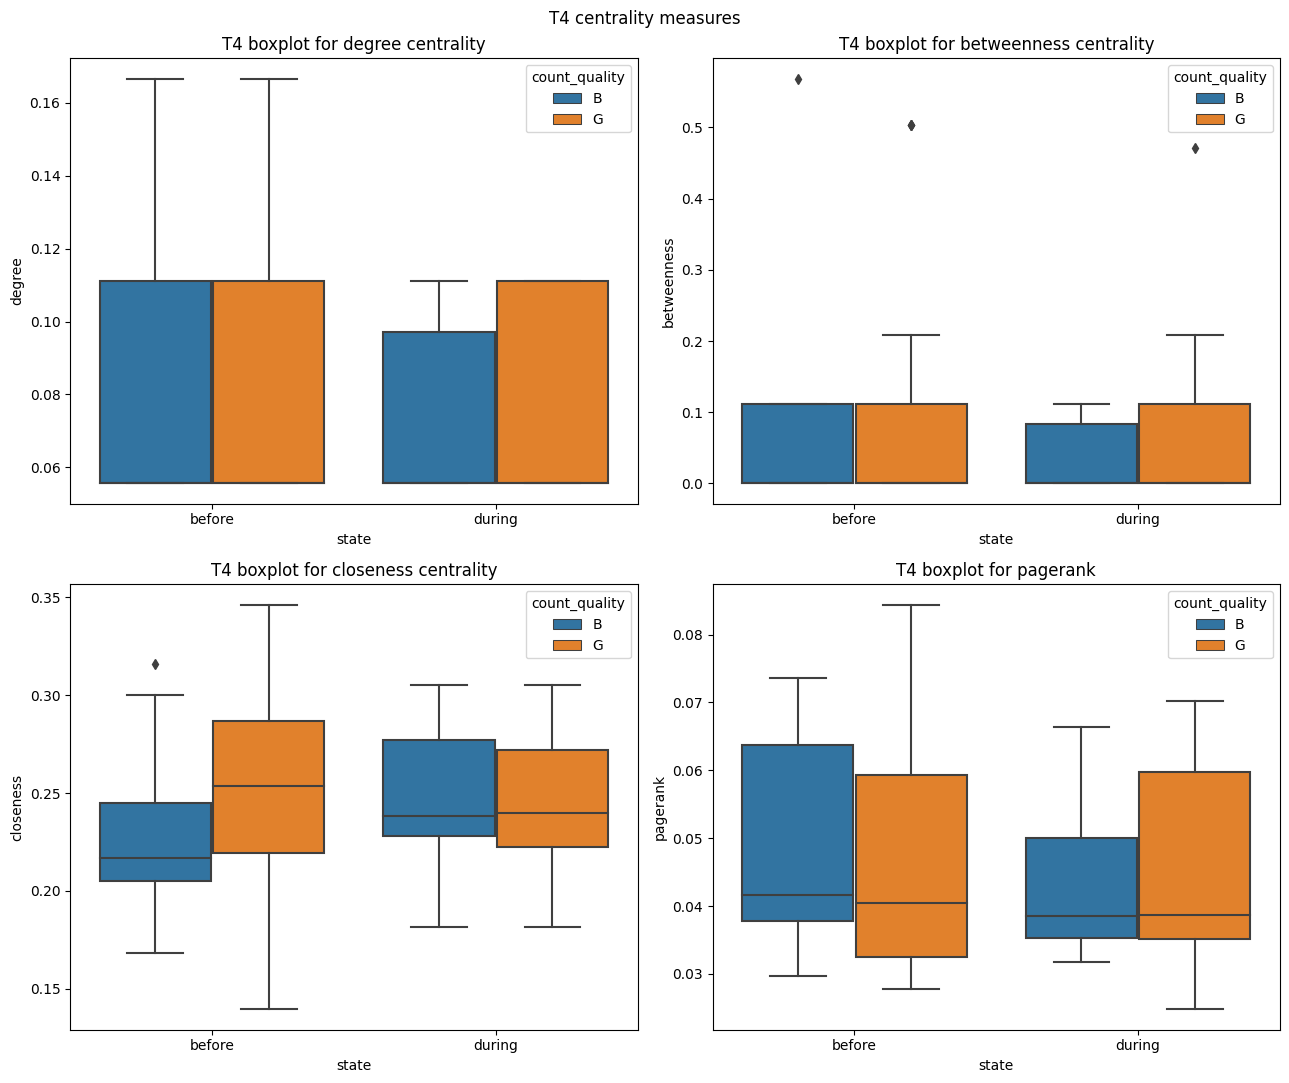

In [154]:
# Todas las gráficas de T4 para cada métrica diferente
sensor: str = 'T4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

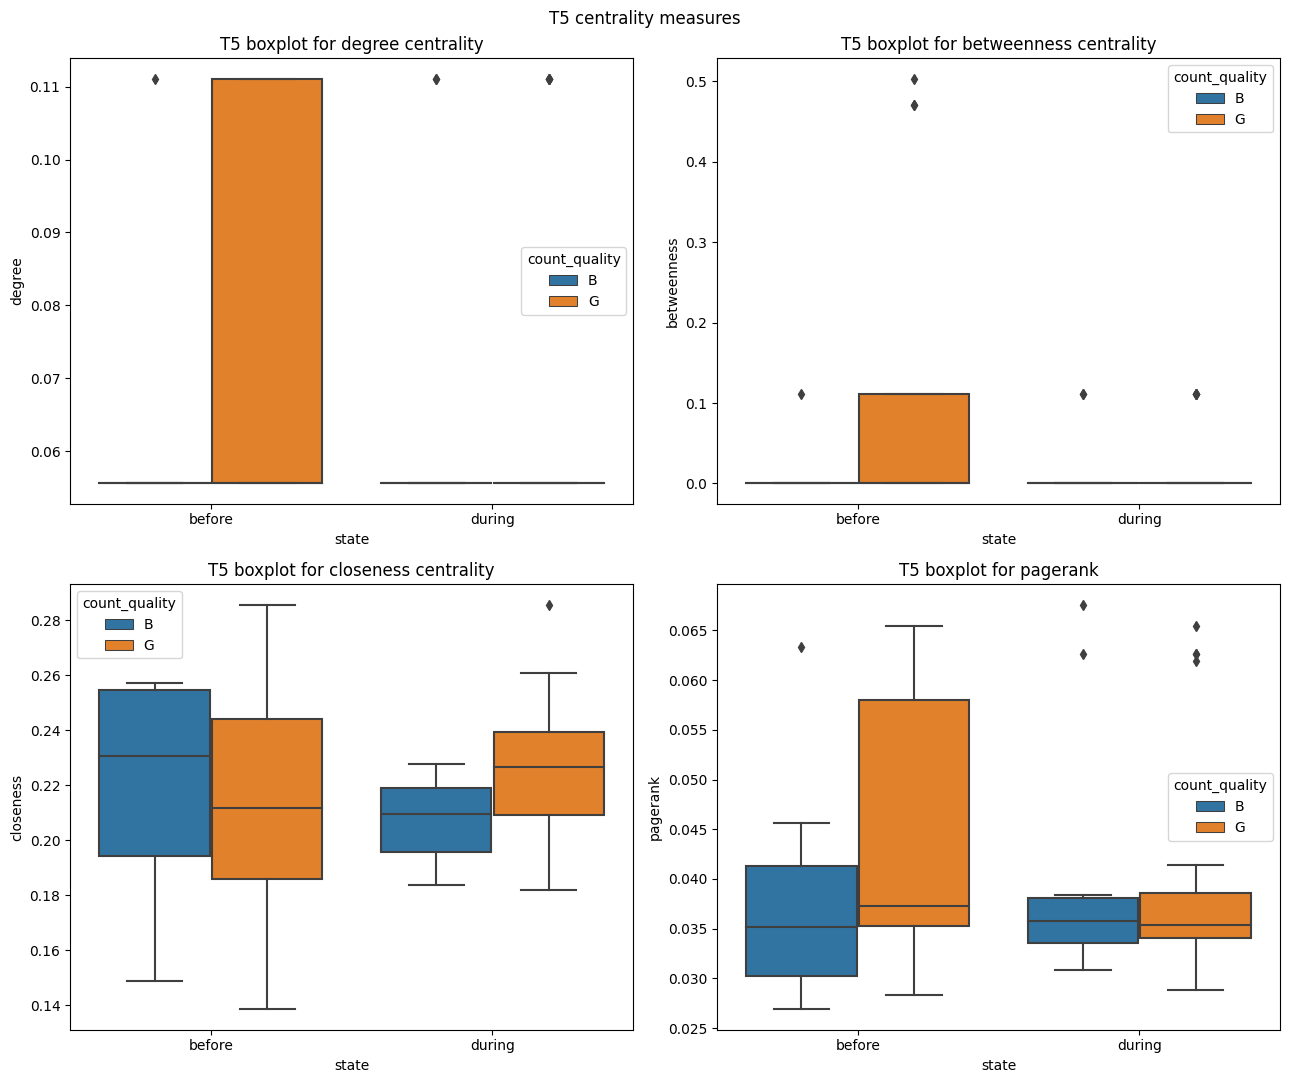

In [155]:
# Todas las gráficas de T5 para cada métrica diferente
sensor: str = 'T5'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

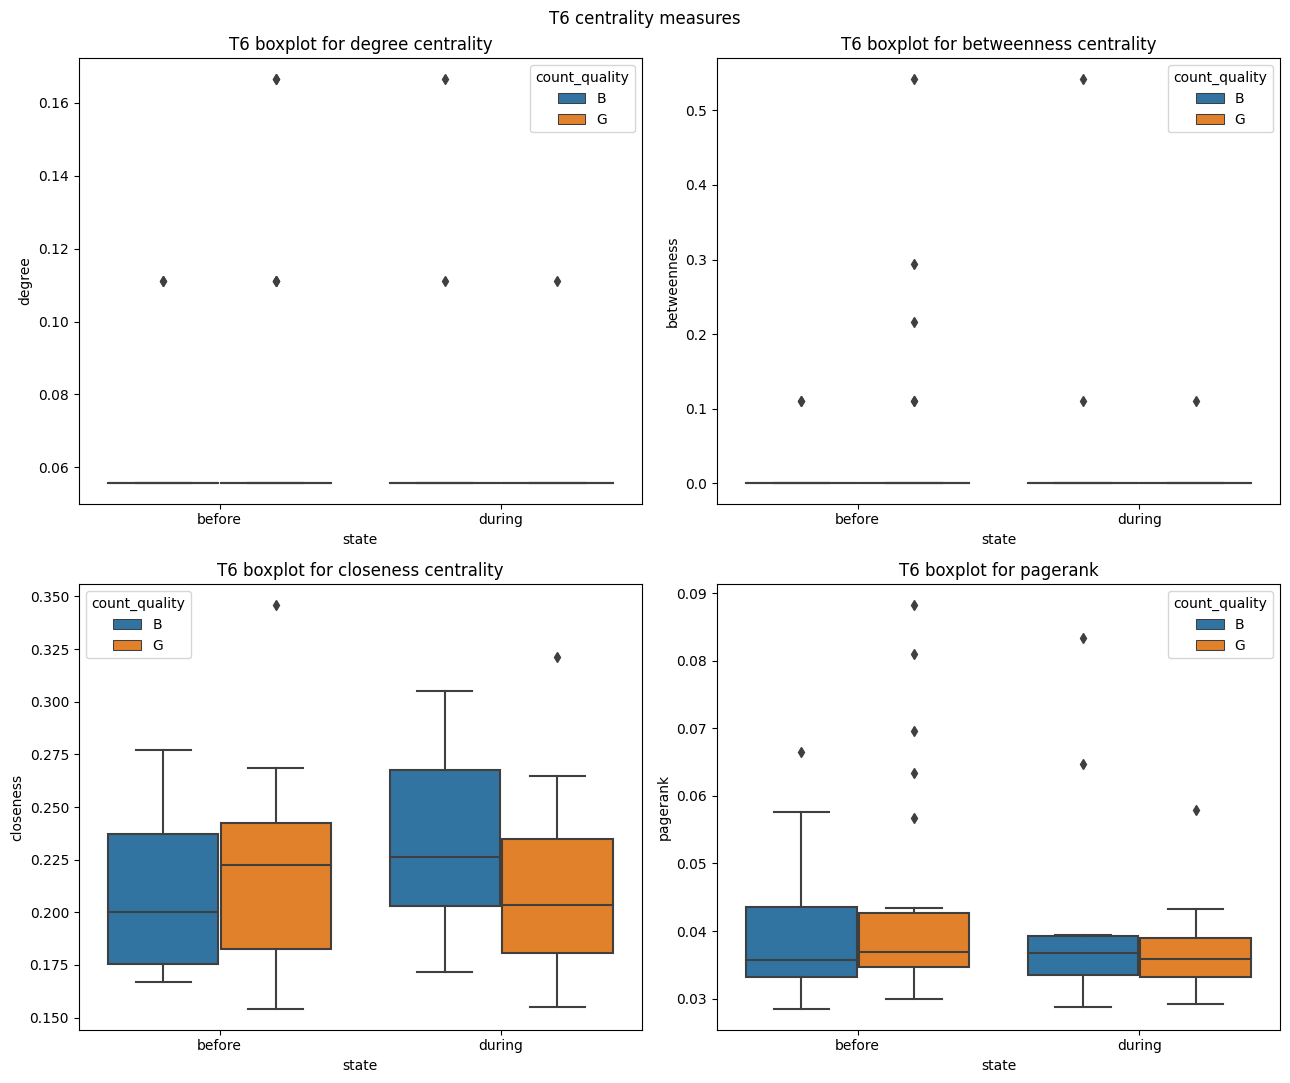

In [156]:
# Todas las gráficas de T6 para cada métrica diferente
sensor: str = 'T6'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

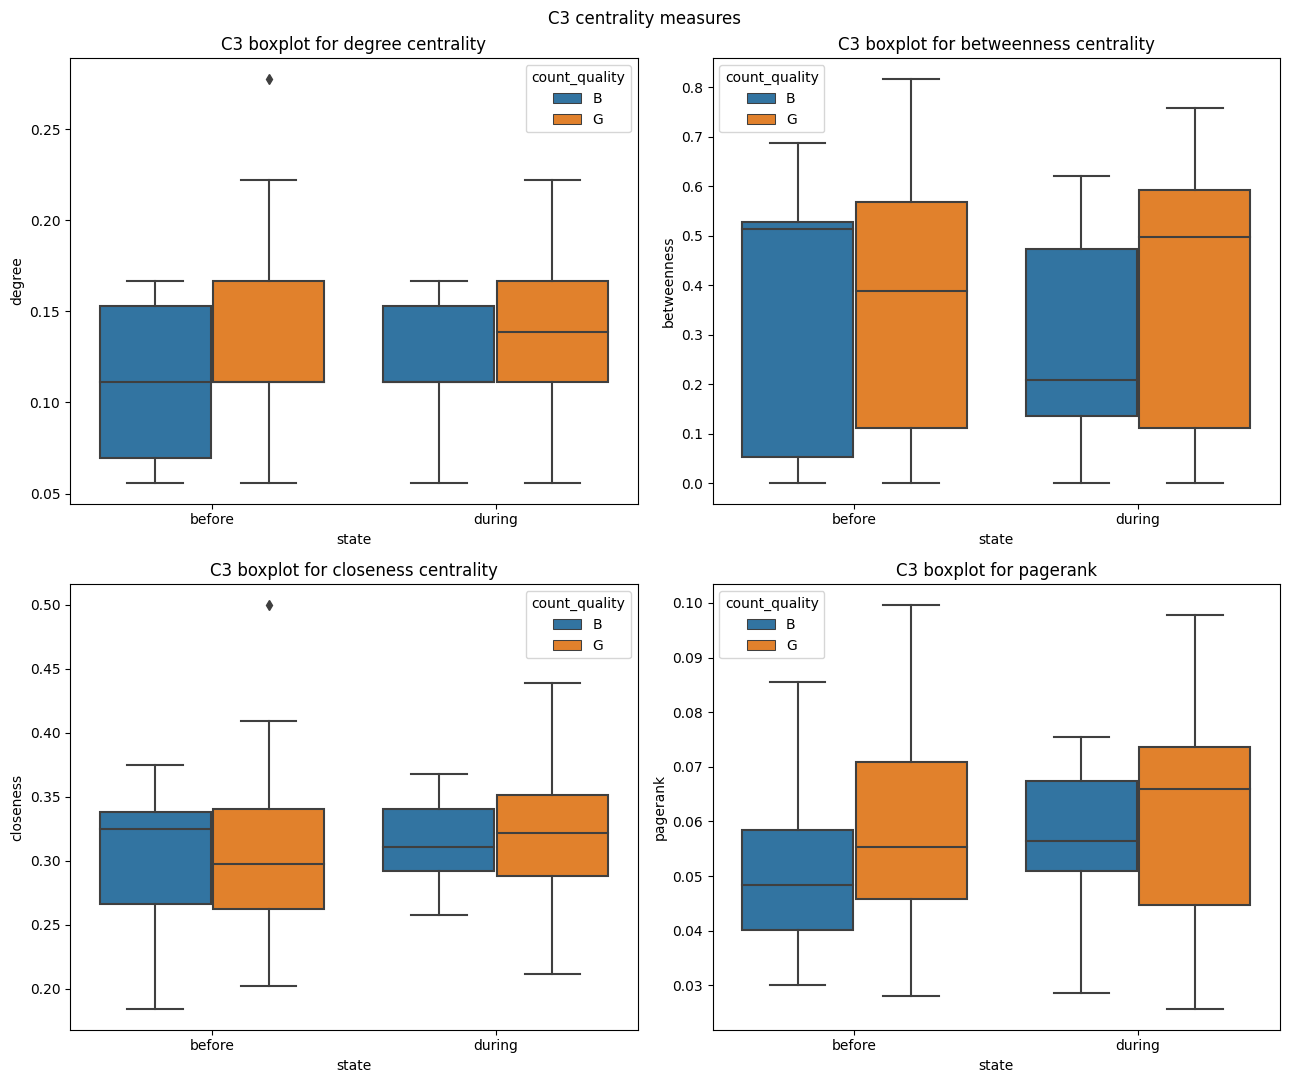

In [157]:
# Todas las gráficas de C3 para cada métrica diferente
sensor: str = 'C3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

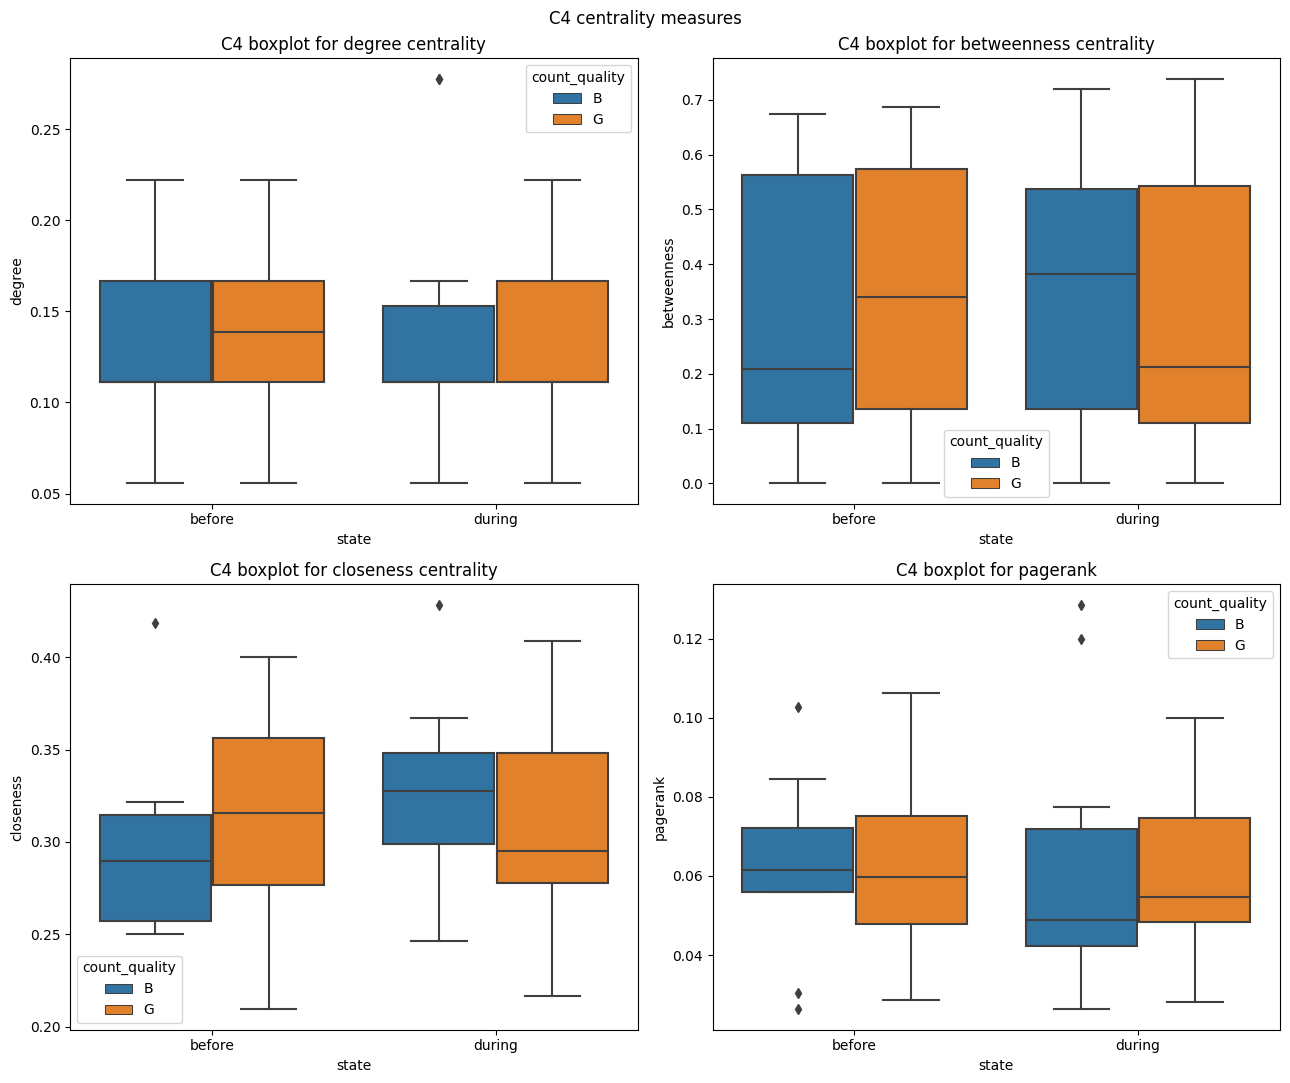

In [158]:
# Todas las gráficas de C4 para cada métrica diferente
sensor: str = 'C4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

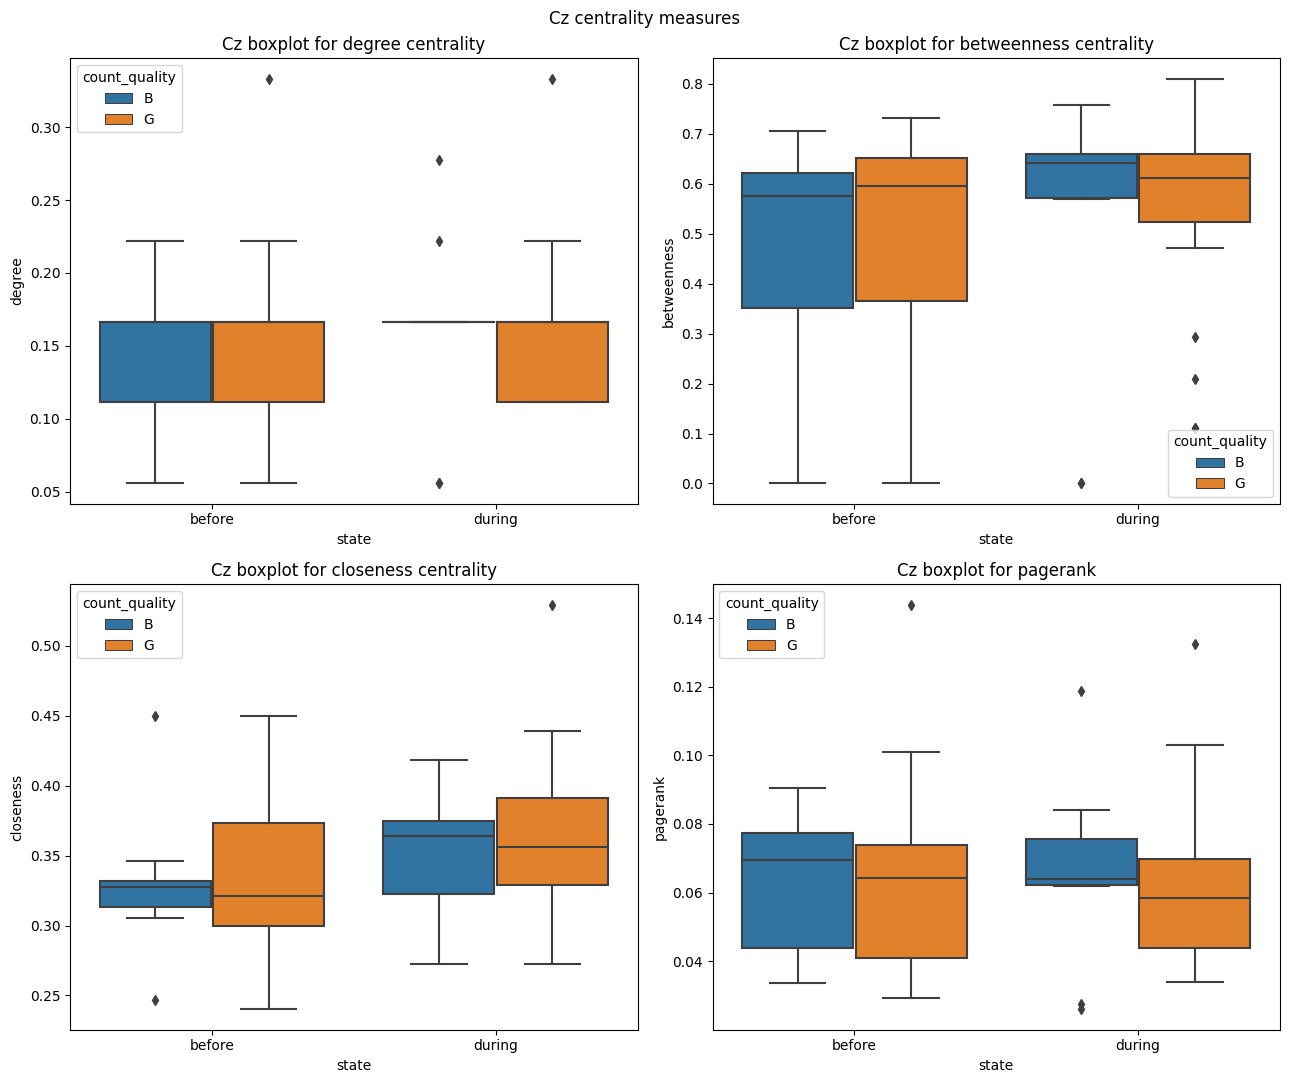

In [159]:
# Todas las gráficas de Cz para cada métrica diferente
sensor: str = 'Cz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

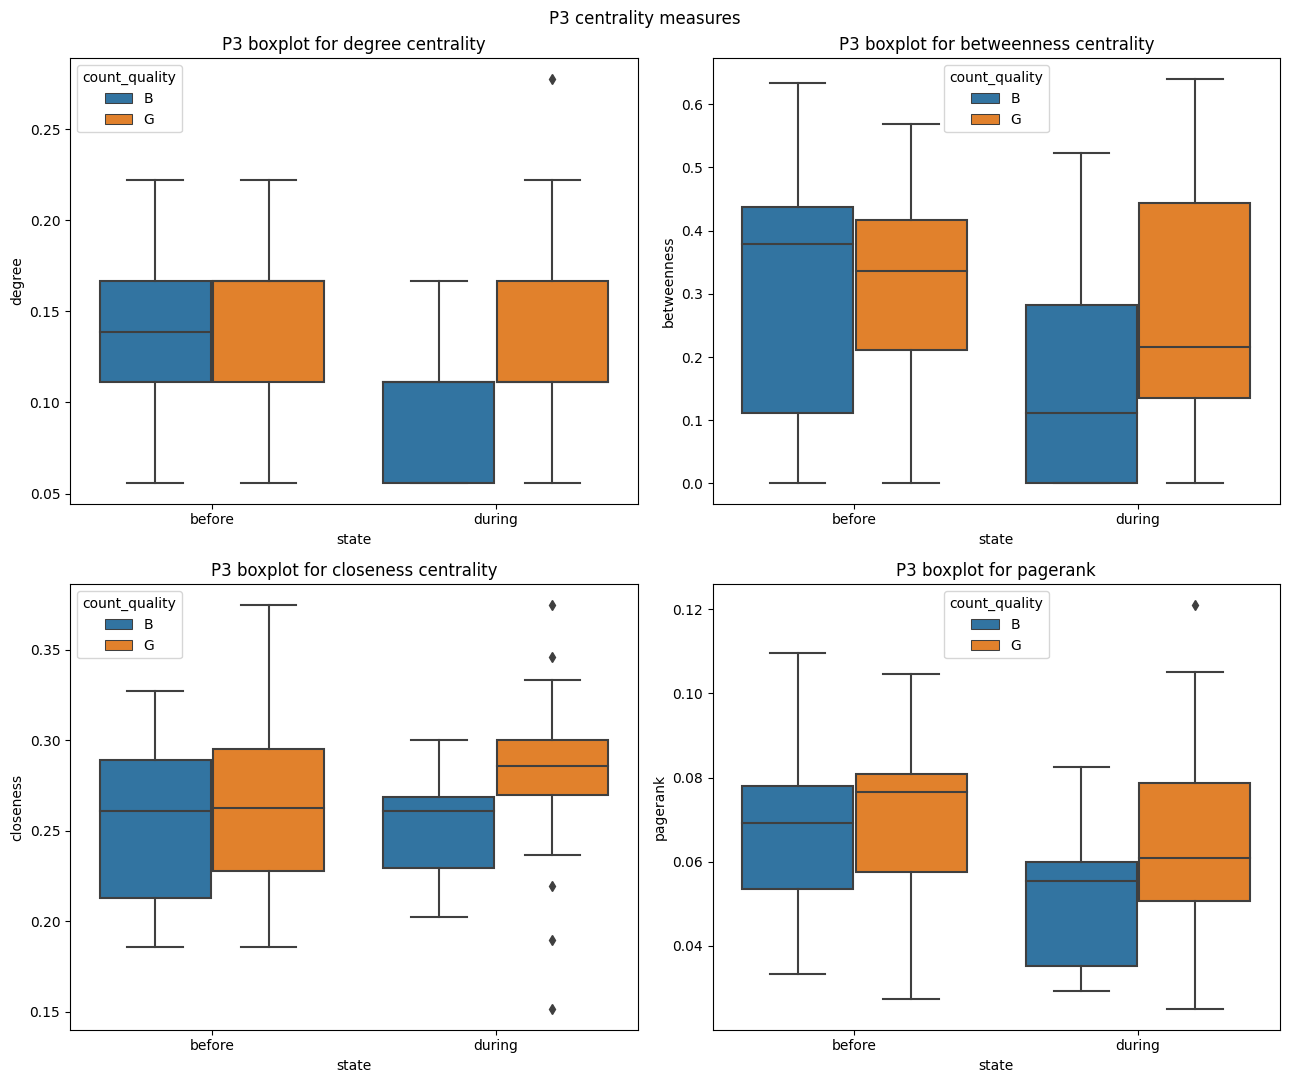

In [160]:
# Todas las gráficas de P3 para cada métrica diferente
sensor: str = 'P3'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

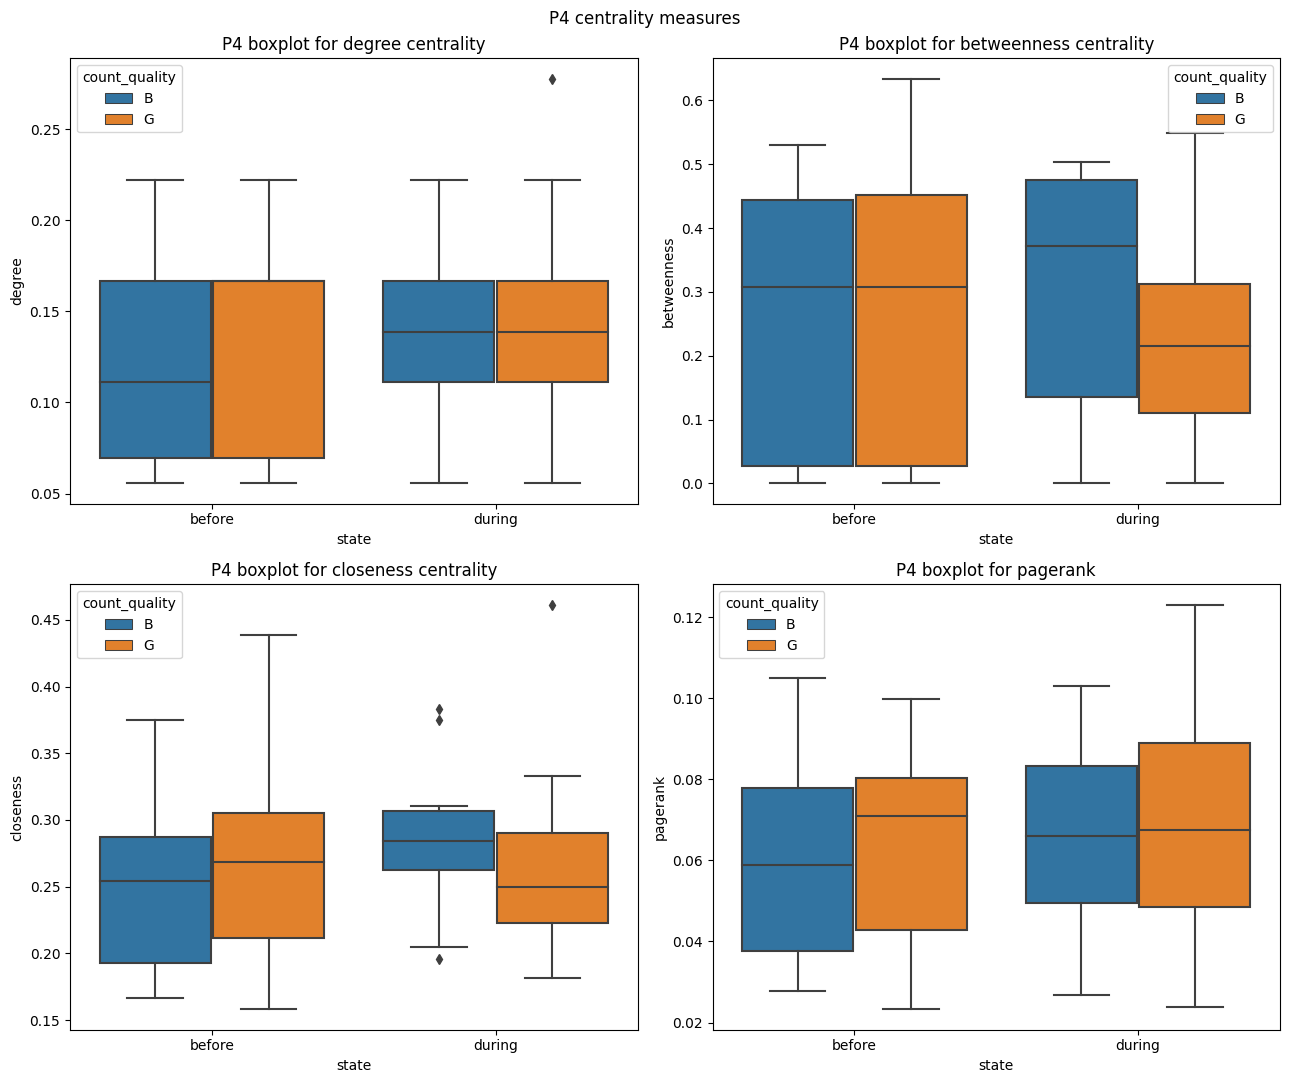

In [161]:
# Todas las gráficas de P4 para cada métrica diferente
sensor: str = 'P4'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

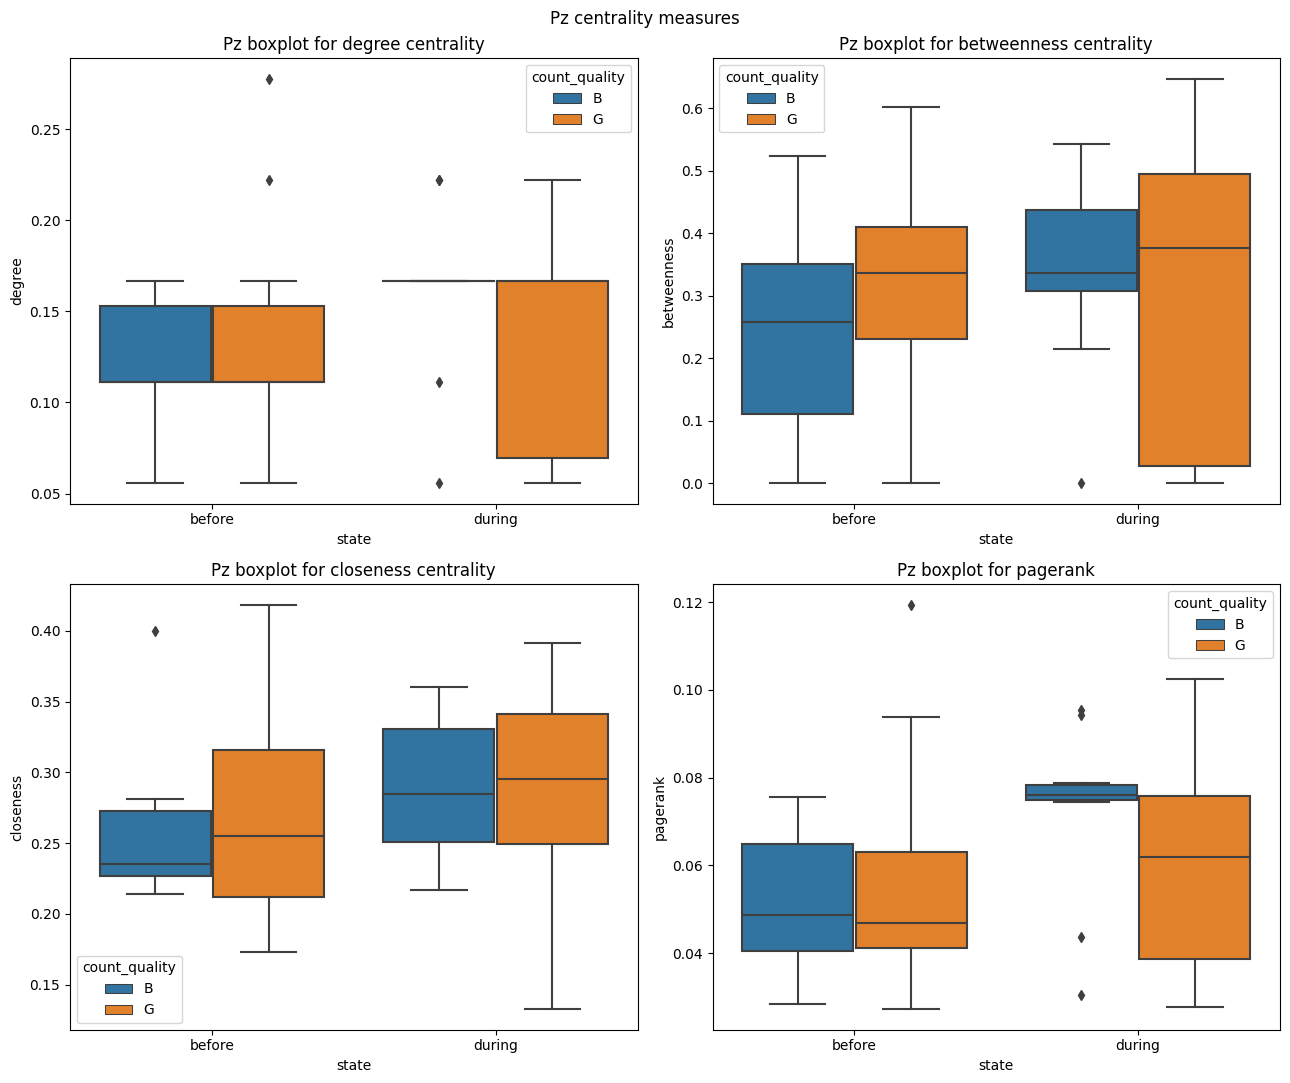

In [162]:
# Todas las gráficas de Pz para cada métrica diferente
sensor: str = 'Pz'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

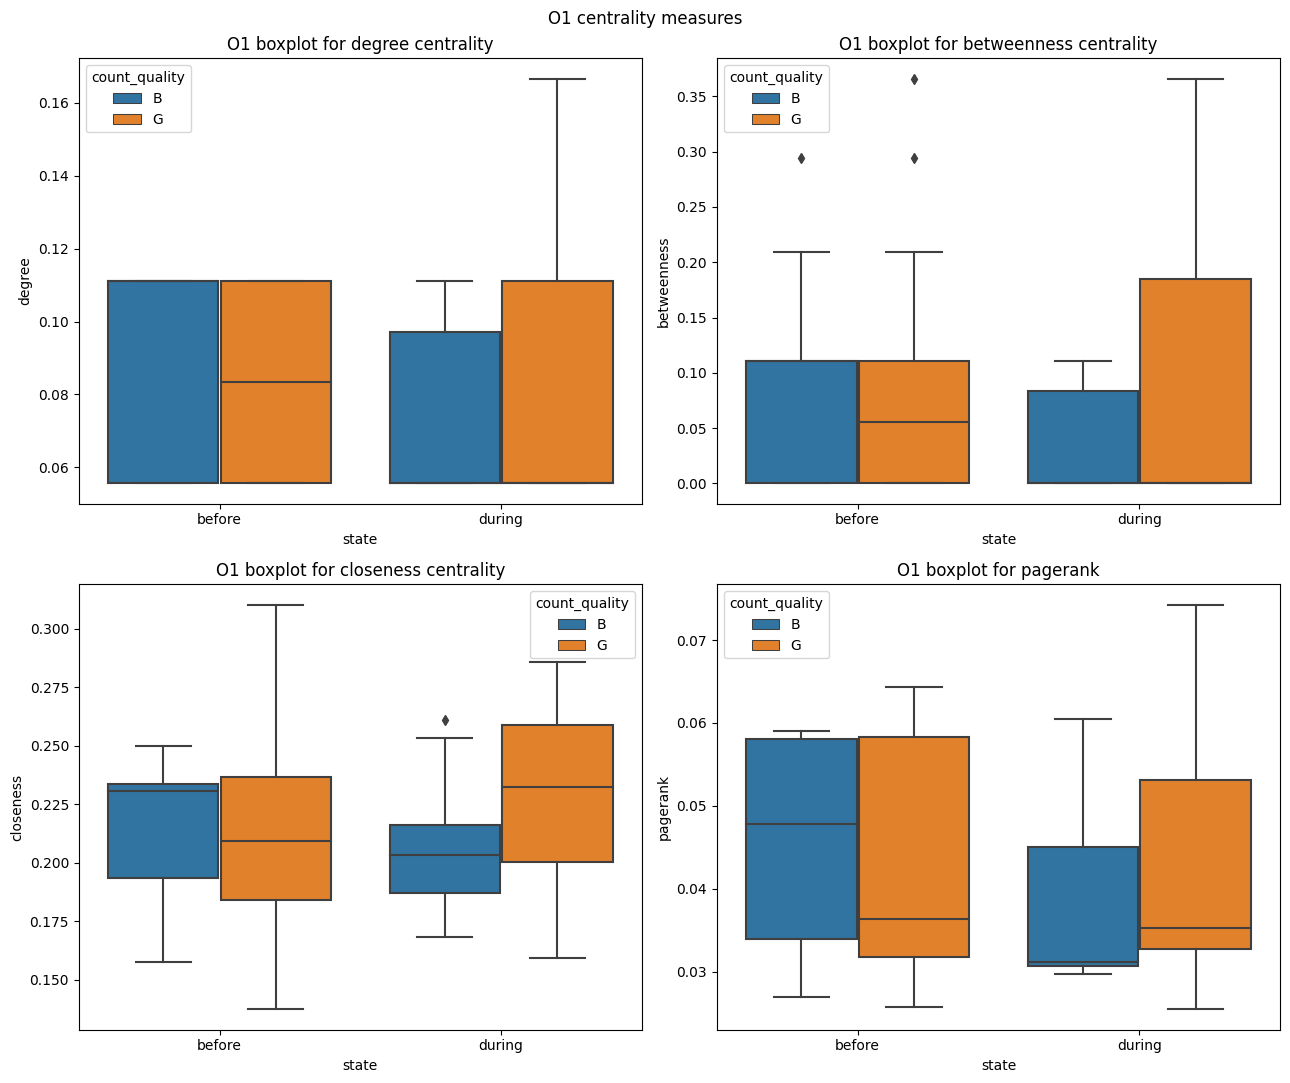

In [163]:
# Todas las gráficas de O1 para cada métrica diferente
sensor: str = 'O1'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

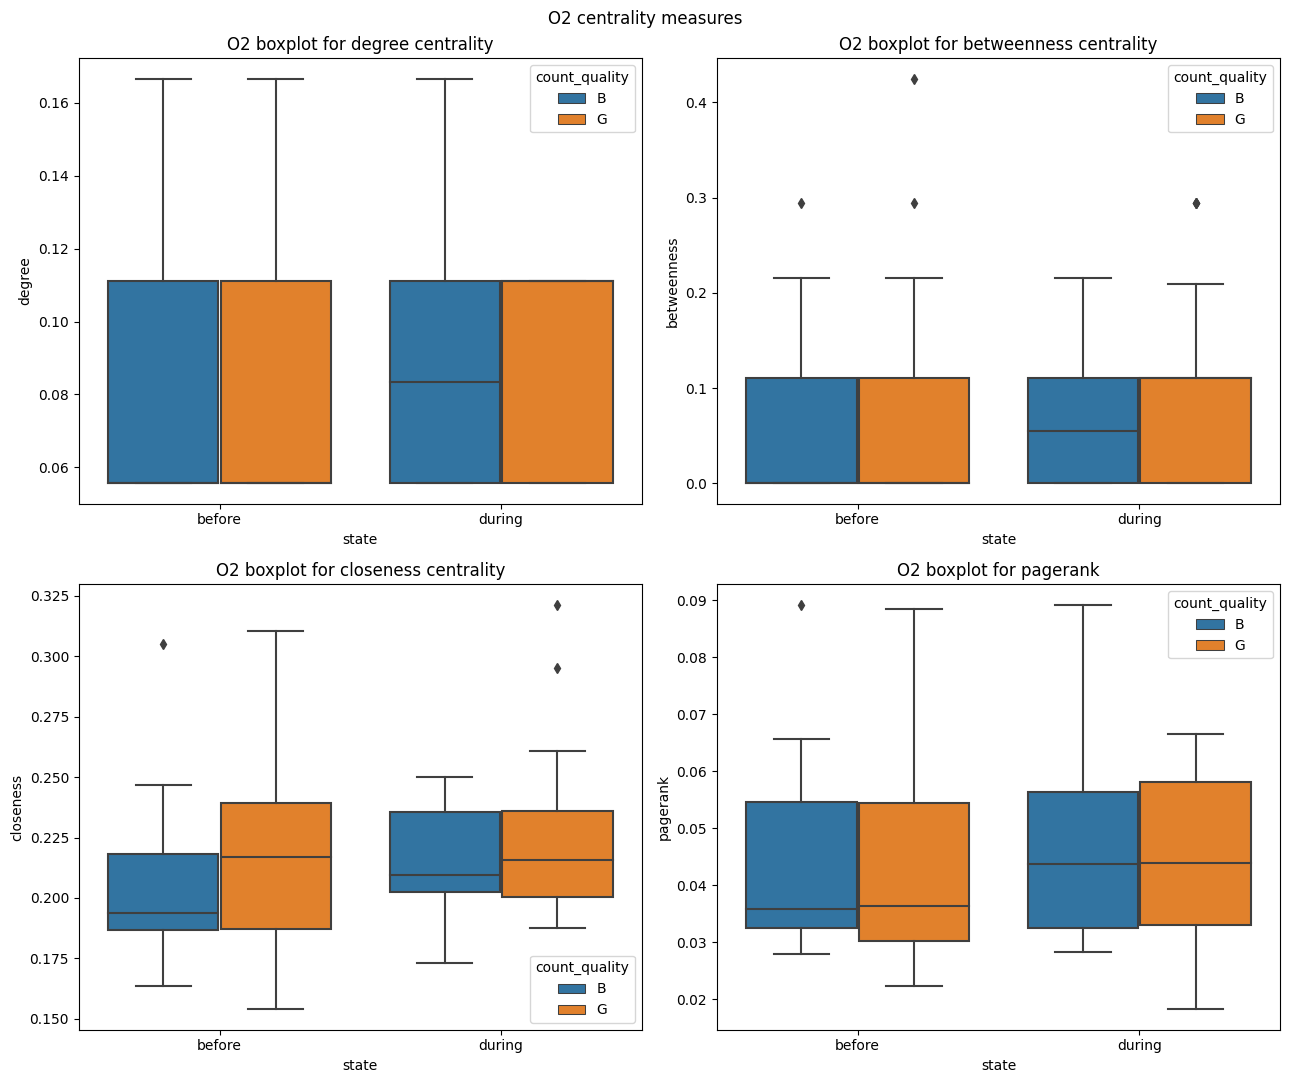

In [164]:
# Todas las gráficas de O2 para cada métrica diferente
sensor: str = 'O2'
df_sensor = df_result[df_result['nodes'] == sensor]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

fig.suptitle(f'{sensor} centrality measures')

ax1.set_title(f'{sensor} boxplot for degree centrality')
sns.boxplot(
    df_sensor, x='state', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title(f'{sensor} boxplot for betweenness centrality')
sns.boxplot(
    df_sensor, x='state', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title(f'{sensor} boxplot for closeness centrality')
sns.boxplot(
    df_sensor, x='state', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title(f'{sensor} boxplot for pagerank')
sns.boxplot(
    df_sensor, x='state', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

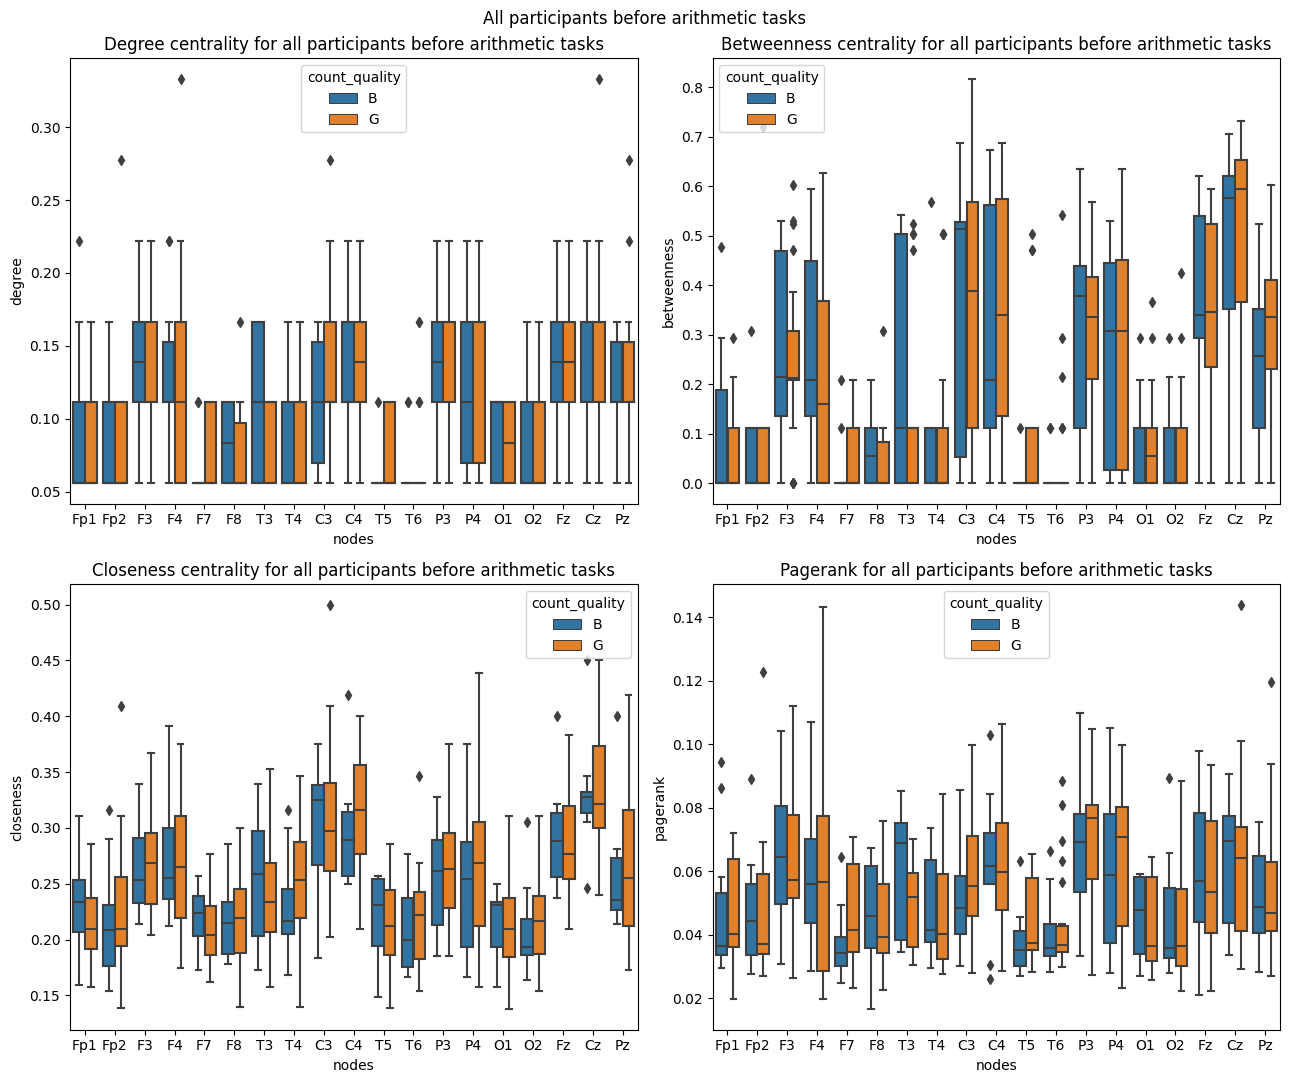

In [165]:
# Todos los nodos de los participantes antes

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants before arithmetic tasks')

ax1.set_title('Degree centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants before arithmetic tasks')
sns.boxplot(
    df_before, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

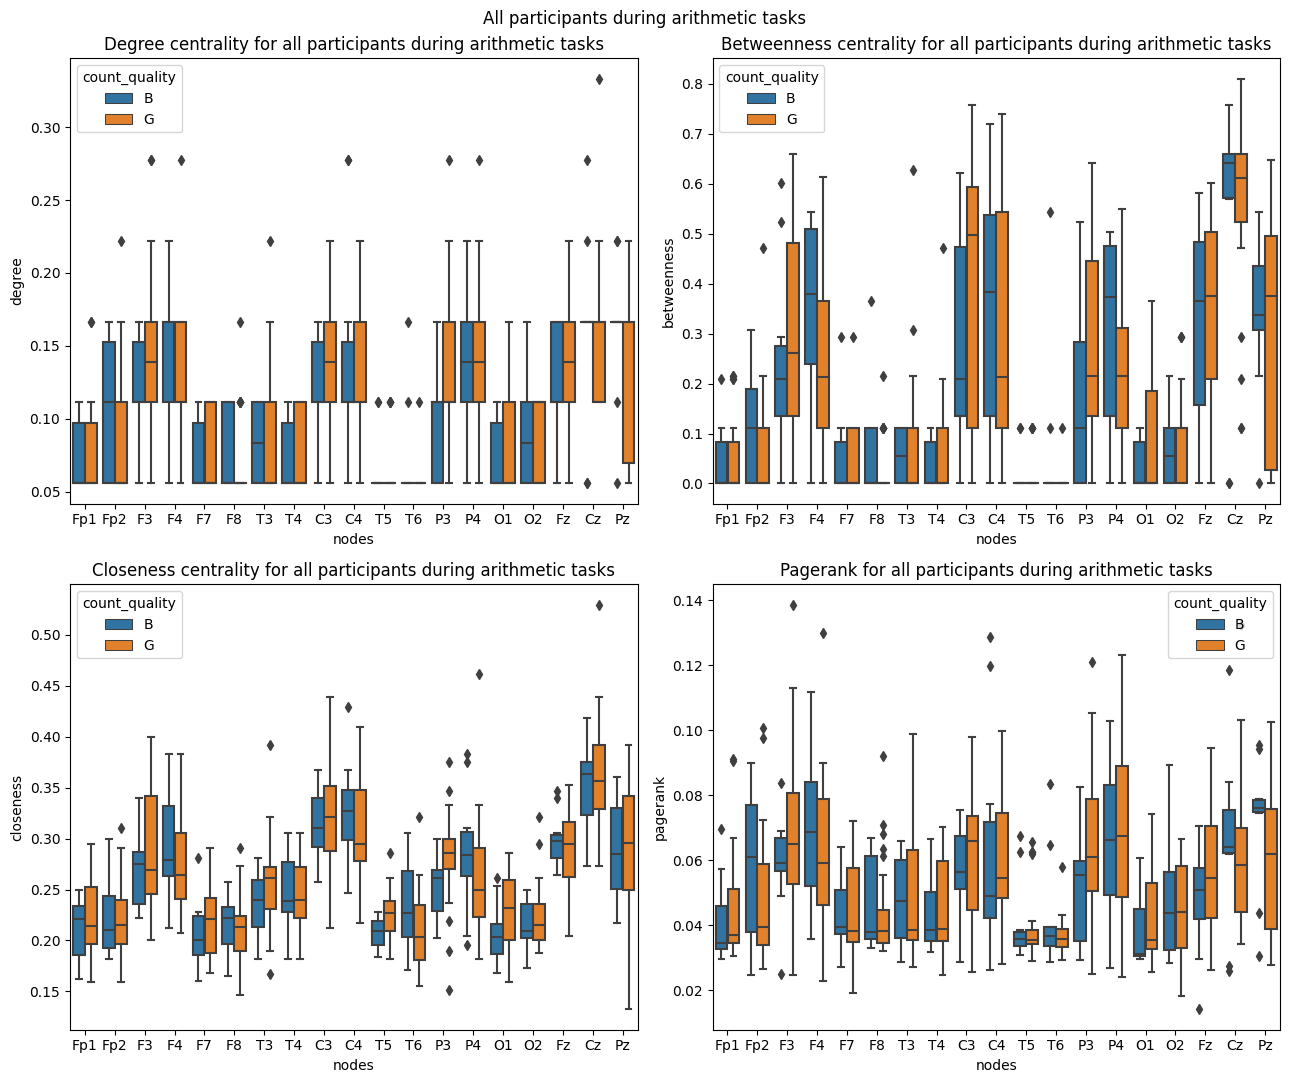

In [166]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants during arithmetic tasks')

ax1.set_title('Degree centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='degree', hue='count_quality', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='betweenness', hue='count_quality', ax=ax2
)

ax3.set_title('Closeness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='closeness', hue='count_quality', ax=ax3
)

ax4.set_title('Pagerank for all participants during arithmetic tasks')
sns.boxplot(
    df_during, x='nodes', y='pagerank', hue='count_quality', ax=ax4
)

plt.tight_layout()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

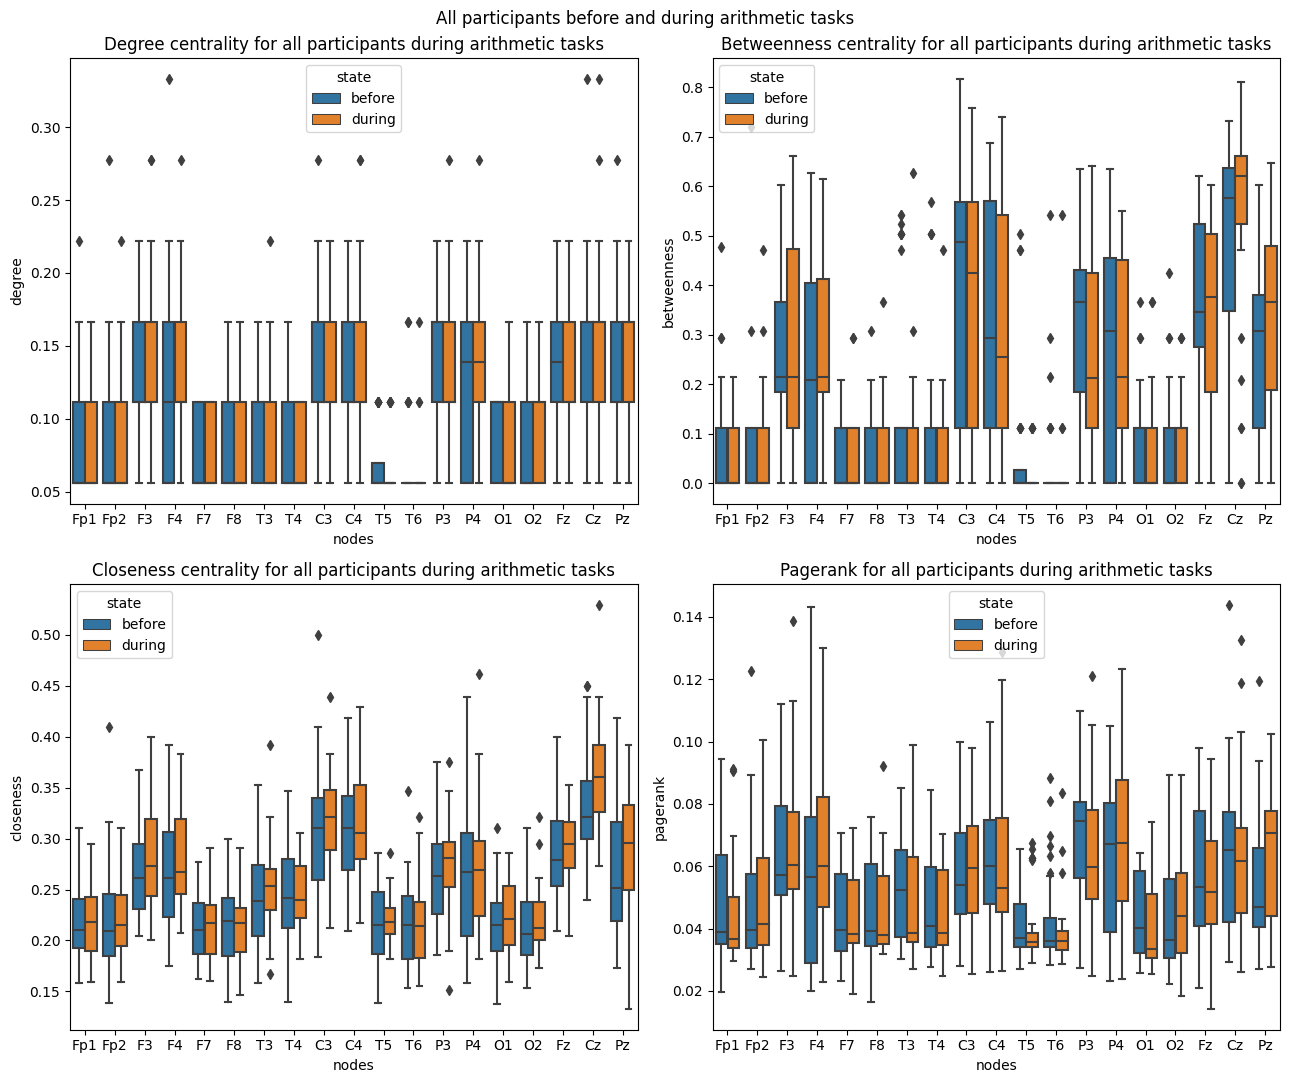

In [169]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('All participants before and during arithmetic tasks')

ax1.set_title('Degree centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='degree', hue='state', ax=ax1
)

ax2.set_title('Betweenness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='betweenness', hue='state', ax=ax2
)

ax3.set_title('Closeness centrality for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='closeness', hue='state', ax=ax3
)

ax4.set_title('Pagerank for all participants during arithmetic tasks')
sns.boxplot(
    df_result, x='nodes', y='pagerank', hue='state', ax=ax4
)

plt.tight_layout()

In [ ]:
# Obtener el promedio de la matriz de distancias
n = 35 + 1

ave_before = np.zeros((19, 19))
ave_during = np.zeros((19, 19))

for i in range(n):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    ave_before += get_distances(csv_path1)
    ave_during += get_distances(csv_path2)

ave_before /= n
ave_during /= n

df_centrality_ave_bef = get_centrality_from_df(ave_before)
df_centrality_ave_dur = get_centrality_from_df(ave_during)

df_centrality_ave_bef.to_csv('Archivos\\ave_centrality_before.csv', sep=';', index=False)
df_centrality_ave_dur.to_csv('Archivos\\ave_centrality_during.csv', sep=';', index=False)

In [ ]:
mst_g_ave_before = get_mst_from_df(ave_before)
mst_g_ave_during = get_mst_from_df(ave_during)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle('Average distances')

ax1.set_title('Before')
nx.draw_networkx(
    mst_g_ave_before,
    nx.planar_layout(mst_g_ave_before),
    ax = ax1
)

ax2.set_title('During')
nx.draw_networkx(
    mst_g_ave_during,
    nx.planar_layout(mst_g_ave_during),
    ax = ax2
)

In [113]:
df_centrality_ave_bef = pd.read_csv('Archivos\\ave_centrality_before.csv', delimiter=';')
df_centrality_ave_bef['status'] = 'before'

df_centrality_ave_dur = pd.read_csv('Archivos\\ave_centrality_before.csv', delimiter=';')
df_centrality_ave_dur['status'] = 'during'

df_centrality_ave = pd.concat([df_centrality_ave_bef, df_centrality_ave_dur], ignore_index=True)

display(df_centrality_ave)

nodes    degree  betweenness  closeness  pagerank  status
0    Fp1  0.055556     0.000000   0.216867  0.034398  before
1    Fp2  0.055556     0.000000   0.216867  0.035419  before
2     F3  0.166667     0.215686   0.272727  0.082879  before
3     F4  0.166667     0.215686   0.272727  0.083671  before
4     F7  0.055556     0.000000   0.216867  0.034718  before
5     F8  0.055556     0.000000   0.216867  0.034652  before
6     T3  0.055556     0.000000   0.272727  0.032019  before
7     T4  0.055556     0.000000   0.225000  0.035615  before
8     C3  0.166667     0.568627   0.367347  0.076639  before
9     C4  0.111111     0.111111   0.285714  0.054815  before
10    T5  0.055556     0.000000   0.253521  0.033170  before
11    T6  0.055556     0.000000   0.189474  0.037177  before
12    P3  0.222222     0.529412   0.333333  0.104072  before
13    P4  0.166667     0.215686   0.230769  0.085667  before
14    O1  0.055556     0.000000   0.253521  0.028538  before
15    O2  0.055556     0.000000   0.189474  0.031326  before
16    Fz  0.166667     0.529412   0.339623  0.063728  before
17    Cz  0.166667     0.620915   0.375000  0.065413  before
18    Pz  0.111111     0.294118   0.276923  0.046086  before
19   Fp1  0.055556     0.000000   0.216867  0.034398  during
20   Fp2  0.055556     0.000000   0.216867  0.035419  during
21    F3  0.166667     0.215686   0.272727  0.082879  during
22    F4  0.166667     0.215686   0.272727  0.083671  during
23    F7  0.055556     0.000000   0.216867  0.034718  during
24    F8  0.055556     0.000000   0.216867  0.034652  during
25    T3  0.055556     0.000000   0.272727  0.032019  during
26    T4  0.055556     0.000000   0.225000  0.035615  during
27    C3  0.166667     0.568627   0.367347  0.076639  during
28    C4  0.111111     0.111111   0.285714  0.054815  during
29    T5  0.055556     0.000000   0.253521  0.033170  during
30    T6  0.055556     0.000000   0.189474  0.037177  during
31    P3  0.222222     0.529412   0.333333  0.104072  during
32    P4  0.166667     0.215686   0.230769  0.085667  during
33    O1  0.055556     0.000000   0.253521  0.028538  during
34    O2  0.055556     0.000000   0.189474  0.031326  during
35    Fz  0.166667     0.529412   0.339623  0.063728  during
36    Cz  0.166667     0.620915   0.375000  0.065413  during
37    Pz  0.111111     0.294118   0.276923  0.046086  during

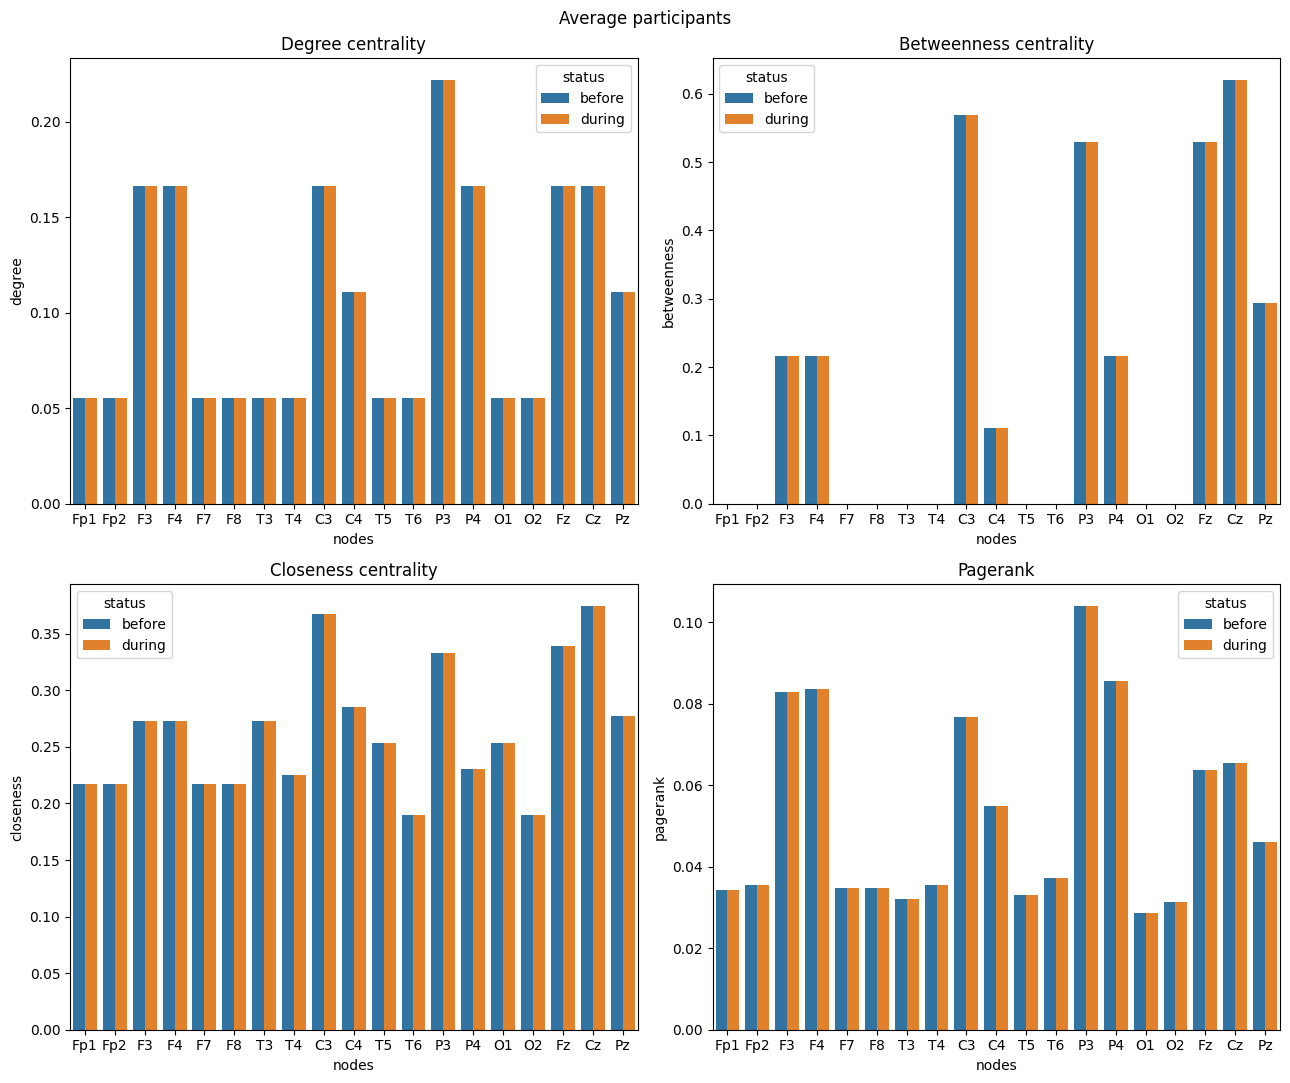

In [114]:
# Todos los nodos de los participantes durante

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants')

ax1.set_title('Degree centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='degree', hue='status', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='betweenness', hue='status', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_centrality_ave, x='nodes', y='closeness', hue='status', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_centrality_ave, x='nodes', y='pagerank', hue='status', ax=ax4
)

plt.tight_layout()

In [ ]:
# Promedio de las personas dependiendo de su calidad de conteo (antes y durante)

ave_b_before, ave_g_before = np.zeros((19, 19)), np.zeros((19, 19))
ave_b_during, ave_g_during = np.zeros((19, 19)), np.zeros((19, 19))
n_b, n_g = 0, 0

for i in range(35 + 1):
    subject = f'Subject{i:02}'
    csv_path1 = f'Archivos\\{subject}\\csv\\{subject}_1.csv'
    csv_path2 = f'Archivos\\{subject}\\csv\\{subject}_2.csv'

    if df_subject_info['Count quality'][i] == 1:
        ave_g_before += get_distances(csv_path1)
        ave_g_during += get_distances(csv_path2)
        n_g += 1
    else:
        ave_b_before += get_distances(csv_path1)
        ave_b_during += get_distances(csv_path2)
        n_b += 1

ave_g_before /= n_g
ave_g_during /= n_g
ave_b_before /= n_b
ave_b_during /= n_b

df_centrality_ave_g_before = get_centrality_from_df(ave_g_before)
df_centrality_ave_g_during = get_centrality_from_df(ave_g_during)
df_centrality_ave_b_before = get_centrality_from_df(ave_b_before)
df_centrality_ave_b_during = get_centrality_from_df(ave_b_during)

df_centrality_ave_g_before['status'] = 'before'
df_centrality_ave_g_during['status'] = 'during'
df_centrality_ave_b_before['status'] = 'before'
df_centrality_ave_b_during['status'] = 'during'

df_centrality_ave_g = pd.concat([df_centrality_ave_g_before, df_centrality_ave_g_during], ignore_index=True)
df_centrality_ave_b = pd.concat([df_centrality_ave_b_before, df_centrality_ave_b_during], ignore_index=True)

df_centrality_ave_g.to_csv('Archivos\\ave_centrality_good.csv', sep=';', index=False)
df_centrality_ave_b.to_csv('Archivos\\ave_centrality_bad.csv', sep=';', index=False)

In [116]:
df_centrality_ave_g = pd.read_csv('Archivos\\ave_centrality_good.csv', delimiter=';')
df_centrality_ave_b = pd.read_csv('Archivos\\ave_centrality_bad.csv', delimiter=';')

df_centrality_ave_g['Count quality'] = 'G'
df_centrality_ave_b['Count quality'] = 'B'

df_centrality_ave_counts = pd.concat([df_centrality_ave_b, df_centrality_ave_g], ignore_index=True)

df_centrality_ave_counts

nodes    degree  betweenness  closeness  pagerank  status Count quality
0    Fp1  0.111111     0.111111   0.216867  0.061987  before             B
1    Fp2  0.055556     0.000000   0.180000  0.035518  before             B
2     F3  0.111111     0.209150   0.264706  0.049925  before             B
3     F4  0.111111     0.209150   0.264706  0.050579  before             B
4     F7  0.055556     0.000000   0.180000  0.035466  before             B
..   ...       ...          ...        ...       ...     ...           ...
71    O1  0.055556     0.000000   0.165138  0.032681  during             G
72    O2  0.111111     0.111111   0.195652  0.058685  during             G
73    Fz  0.166667     0.529412   0.321429  0.061987  during             G
74    Cz  0.166667     0.620915   0.352941  0.063293  during             G
75    Pz  0.111111     0.366013   0.272727  0.045821  during             G

[76 rows x 7 columns]

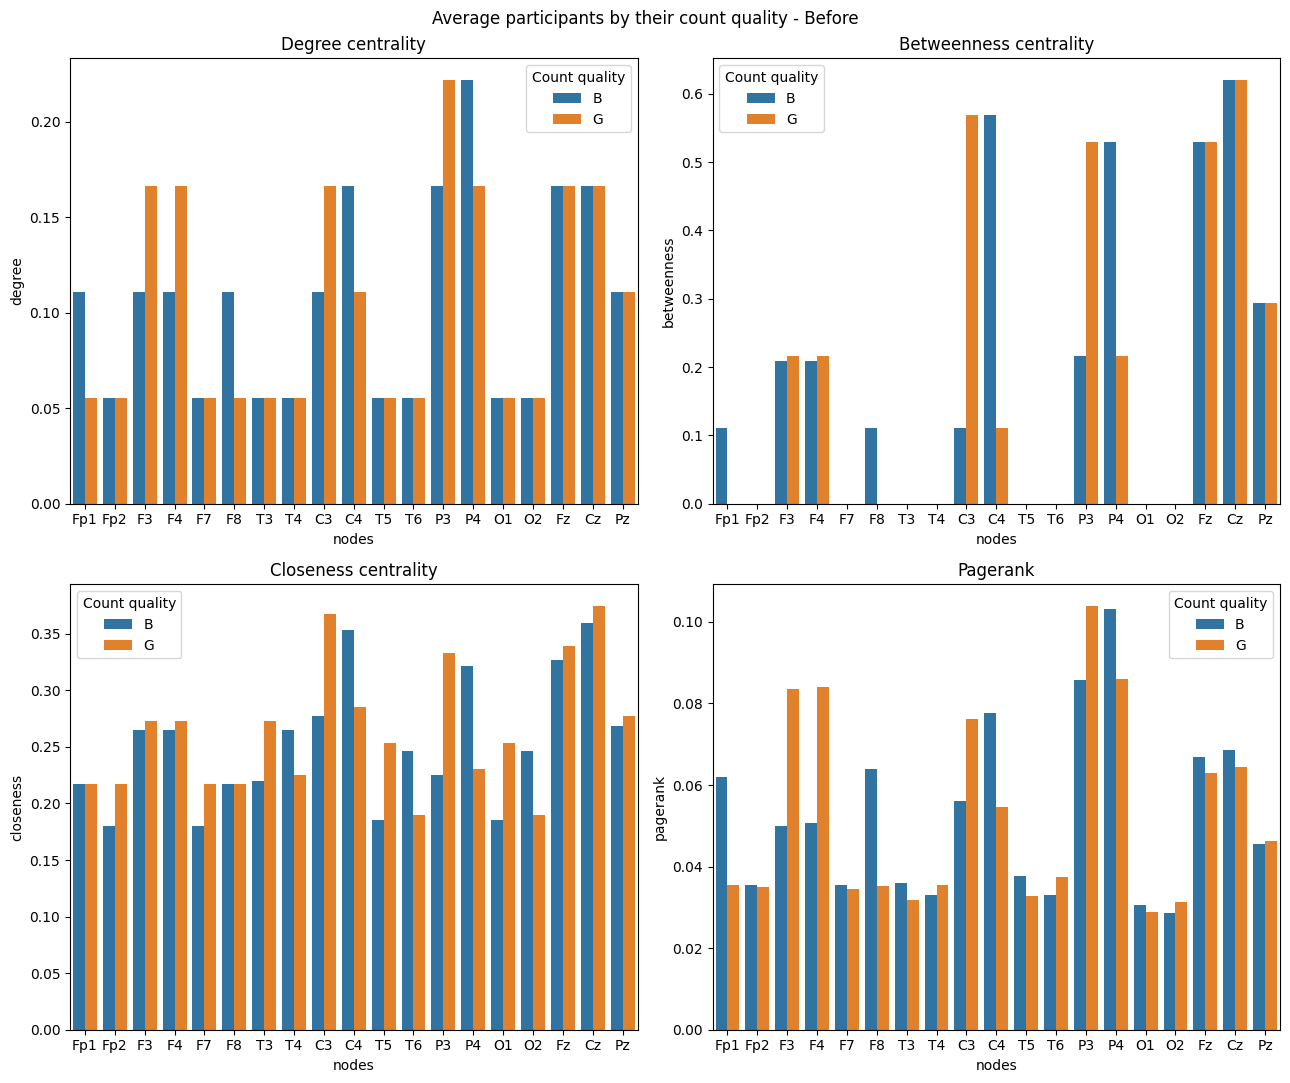

In [117]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'before']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - Before')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(    
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()

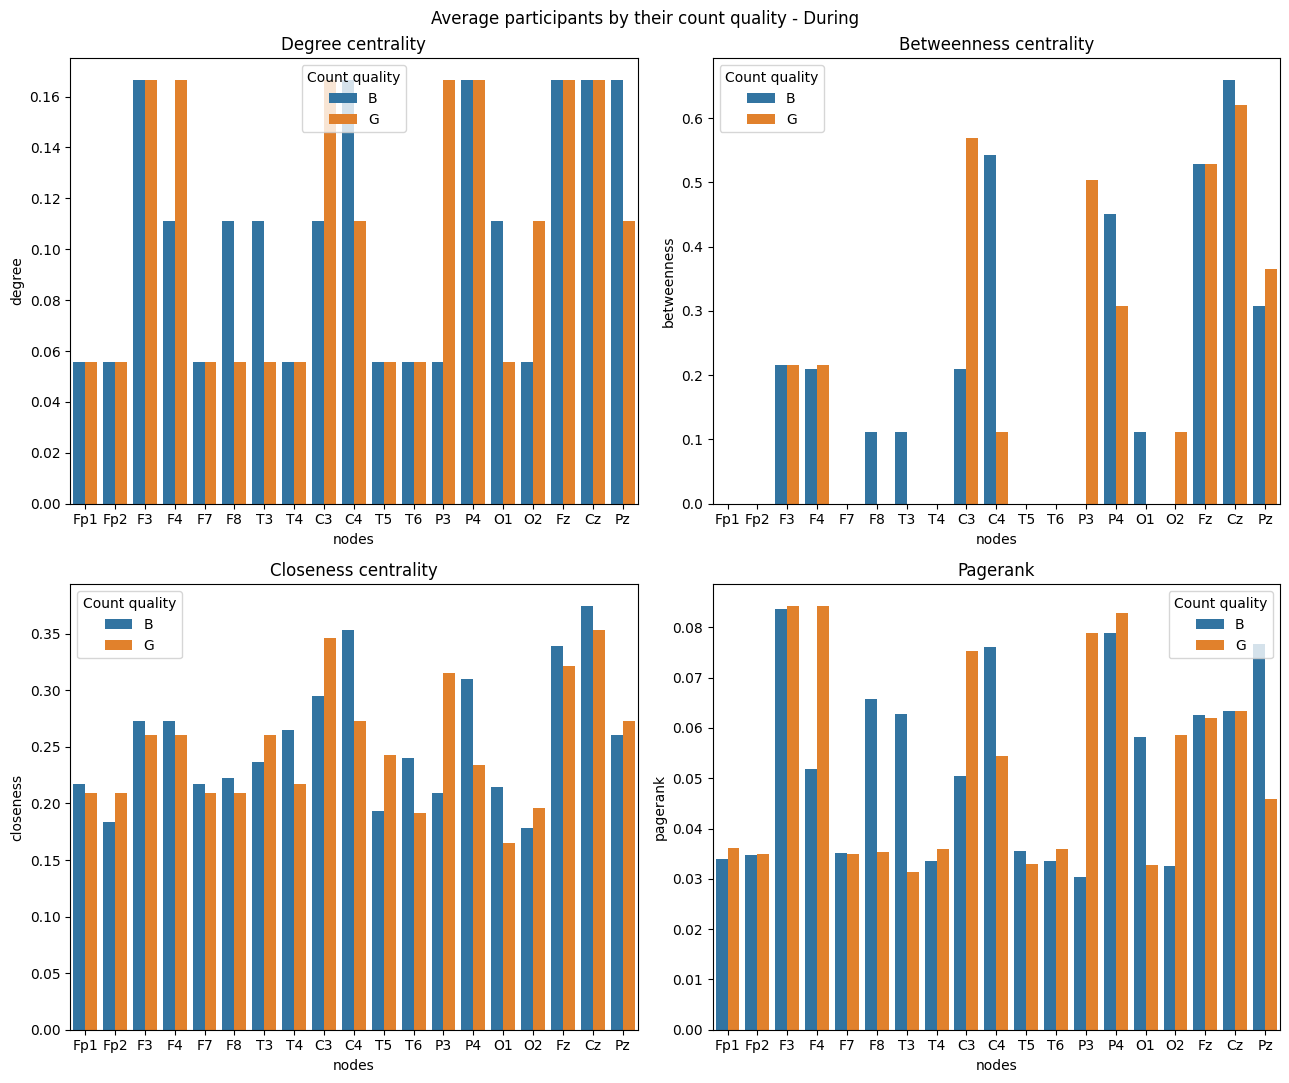

In [118]:
df_temp1 = df_centrality_ave_counts[df_centrality_ave_counts['status'] == 'during']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 11))
fig.suptitle('Average participants by their count quality - During')

ax1.set_title('Degree centrality')
sns.barplot(
    df_temp1, x='nodes', y='degree', hue='Count quality', ax=ax1
)

ax2.set_title('Betweenness centrality')
sns.barplot(
    df_temp1, x='nodes', y='betweenness', hue='Count quality', ax=ax2
)

ax3.set_title('Closeness centrality')
sns.barplot(
    df_temp1, x='nodes', y='closeness', hue='Count quality', ax=ax3
)

ax4.set_title('Pagerank')
sns.barplot(
    df_temp1, x='nodes', y='pagerank', hue='Count quality', ax=ax4
)

plt.tight_layout()

In [82]:
file_example = 'Archivos/Subject00/csv/Subject00_1.csv'
mst_g0 = get_mst(file_example)
centralities = centrality(file_example)


# Poner la medida de centralidad para cada uno de los nodos
for i, node in enumerate(CHANNELS):
    mst_g0.nodes[node]['degree'] = round(centralities['degree'][i], 2)
    mst_g0.nodes[node]['betweenness'] = round(centralities['betweenness'][i], 2)
    mst_g0.nodes[node]['closeness'] = round(centralities['closeness'][i], 2)
    mst_g0.nodes[node]['pagerank'] = round(centralities['pagerank'][i], 2)

mst_g0.nodes(data=True)

NodeDataView({'Fp1': {'degree': 0.22, 'betweenness': 0.48, 'closeness': 0.27, 'pagerank': 0.09}, 'Fp2': {'degree': 0.11, 'betweenness': 0.11, 'closeness': 0.22, 'pagerank': 0.05}, 'F3': {'degree': 0.11, 'betweenness': 0.11, 'closeness': 0.22, 'pagerank': 0.05}, 'F4': {'degree': 0.17, 'betweenness': 0.54, 'closeness': 0.31, 'pagerank': 0.07}, 'F7': {'degree': 0.06, 'betweenness': 0.0, 'closeness': 0.22, 'pagerank': 0.04}, 'F8': {'degree': 0.06, 'betweenness': 0.0, 'closeness': 0.18, 'pagerank': 0.04}, 'T3': {'degree': 0.06, 'betweenness': 0.0, 'closeness': 0.19, 'pagerank': 0.04}, 'T4': {'degree': 0.17, 'betweenness': 0.57, 'closeness': 0.32, 'pagerank': 0.07}, 'C3': {'degree': 0.06, 'betweenness': 0.0, 'closeness': 0.18, 'pagerank': 0.04}, 'C4': {'degree': 0.17, 'betweenness': 0.58, 'closeness': 0.32, 'pagerank': 0.08}, 'T5': {'degree': 0.06, 'betweenness': 0.0, 'closeness': 0.19, 'pagerank': 0.03}, 'T6': {'degree': 0.06, 'betweenness': 0.0, 'closeness': 0.24, 'pagerank': 0.03}, 'P3': 

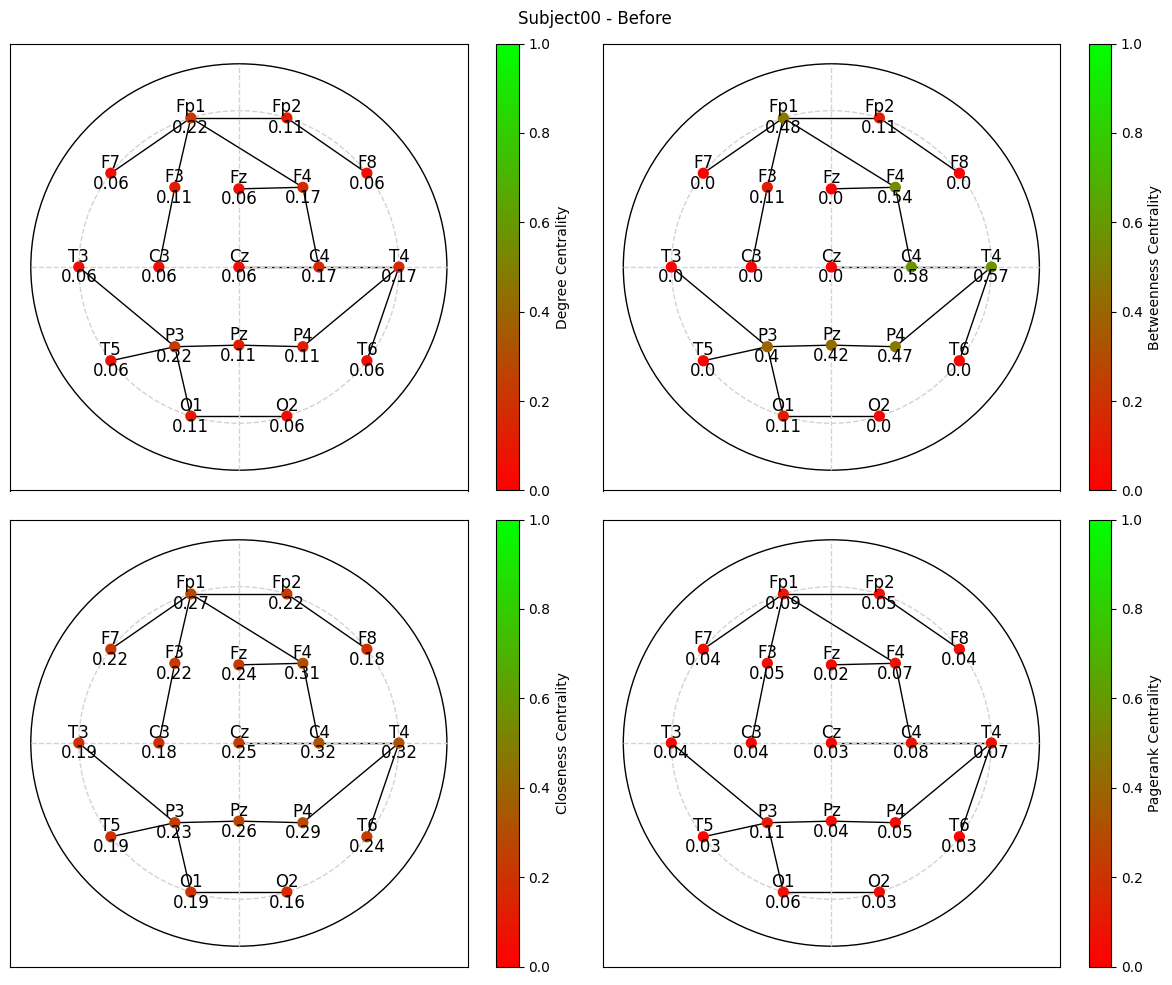

In [89]:
# Las etiquetaas de los nodos se mostrarán aparte

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Define un mapa de colores personalizado para el degradado (rojo a verde)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FF0000', '#00FF00'], N=100)

# Función para asignar un color en función de la medida de centralidad
def get_node_color(i: int, measure: str) -> tuple:
    measure_centrality = centralities.get(measure)
    return cmap(measure_centrality[i])

def plot_measure(G, measure, ax) -> None:
    # En caso de querer ver los nodos y la medida de centralidad
    temp_labels = {node: f'{node}\n{temp_centrality[measure]}' for node, temp_centrality in G.nodes(data=True)}

    ax.add_patch(Circle((0, 0), radius=1.3, color='black', fill=False, linewidth=1))
    ax.add_patch(Circle((0, 0), radius=1, color='lightgray', fill=False, linestyle='--', linewidth=1))

    # Agregar segmentos
    ax.plot([0, 0], [-1.3, 1.3], linestyle='--', color='lightgray', linewidth=1)
    ax.plot([-1.3, 1.3], [0, 0], linestyle='--', color='lightgray', linewidth=1)

    nx.draw_networkx(
        G,
        pos,
        node_size=50,
        with_labels=True,
        ax=ax,
        node_color=[get_node_color(i, measure) for i, _ in enumerate(G.nodes())],
        cmap=cmap,
        labels=temp_labels
    )
    
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, label=f'{measure.title()} Centrality', ax=ax)

# Degree
plot_measure(mst_g0, 'degree', ax1)

# Betweenness
plot_measure(mst_g0, 'betweenness', ax2)

# Closeness
plot_measure(mst_g0, 'closeness', ax3)

# Pagerank
plot_measure(mst_g0, 'pagerank', ax4)

fig.suptitle('Subject00 - Before')

plt.tight_layout()
plt.show()

In [25]:
from ipywidgets import interact, FloatSlider
from IPython.display import display

raw_0 = mne.io.read_raw_edf('Archivos\Subject00\edf\Subject00_1.edf')
raw_1 = mne.io.read_raw_edf('Archivos\Subject00\edf\Subject00_2.edf')

raw = mne.concatenate_raws([raw_0, raw_1], preload=True)

# Obtener los electrodos relevantes
raw.drop_channels(['EEG A2-A1', 'ECG ECG'])
raw.rename_channels(lambda eeg: eeg.replace('EEG ', ''))

evoked: mne.Evoked = mne.EvokedArray(raw.get_data(), info=raw.info)

montage = mne.channels.make_standard_montage("standard_1020")
evoked.info.set_montage(montage)

slider = FloatSlider(value=0, min=0, max=(len(raw.times)-1)*2e-3, step=0.002, description="Seconds")

def plot_topomap(time):
    evoked.plot_topomap(
        times=time, ch_type='eeg', show_names=True, size=5
    )

interact(plot_topomap, time=slider)
display(slider)

Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject00\edf\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\perez\OneDrive\Documentos\vscode\semillero\Archivos\Subject00\edf\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


interactive(children=(FloatSlider(value=0.0, description='Seconds', max=243.99800000000002, step=0.002), Outpu…

FloatSlider(value=0.0, description='Seconds', max=243.99800000000002, step=0.002)

Using matplotlib as 2D backend.


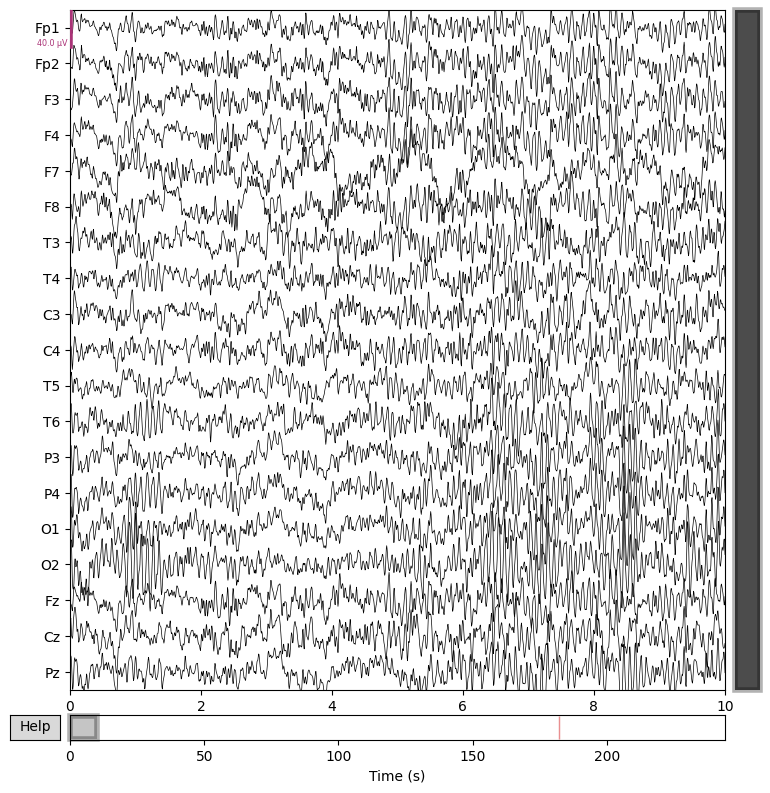

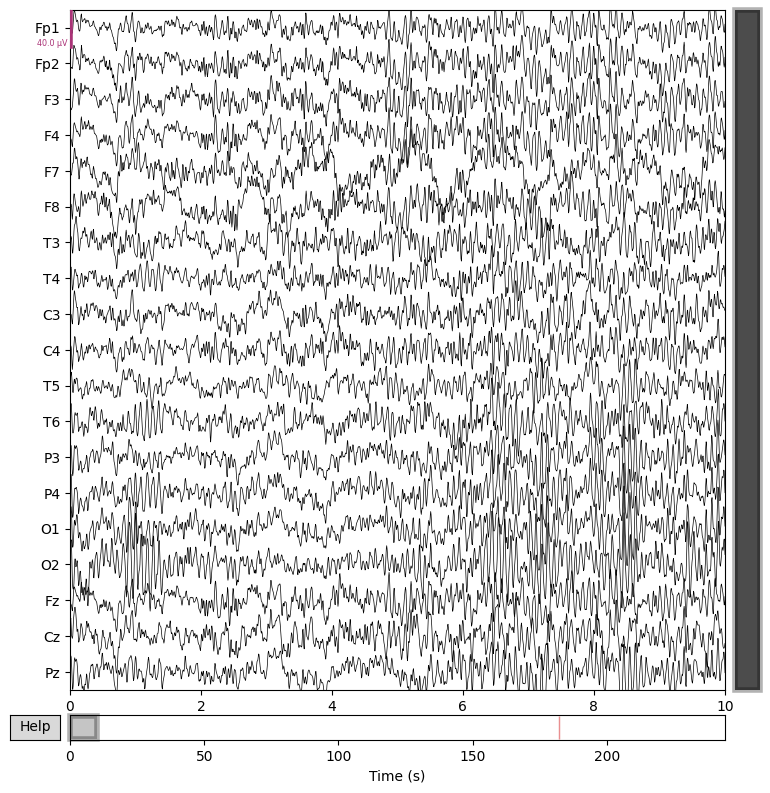

In [26]:
raw.plot()

In [129]:
df_1 = pd.read_csv('Archivos\Subject00\csv\Subject00_1.csv', sep=';')
df_2 = pd.read_csv('Archivos\Subject00\csv\Subject00_2.csv', sep=';')

info = mne.create_info(CHANNELS, ch_types=['eeg']*19, sfreq=500)
info.set_montage("standard_1020")

raw_0 = mne.io.RawArray(df_1, info)
raw_1 = mne.io.RawArray(df_2, info)

raw = mne.concatenate_raws([raw_0, raw_1], preload=True)

Creating RawArray with float64 data, n_channels=19, n_times=91000
    Range : 0 ... 90999 =      0.000 ...   181.998 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=31000
    Range : 0 ... 30999 =      0.000 ...    61.998 secs
Ready.


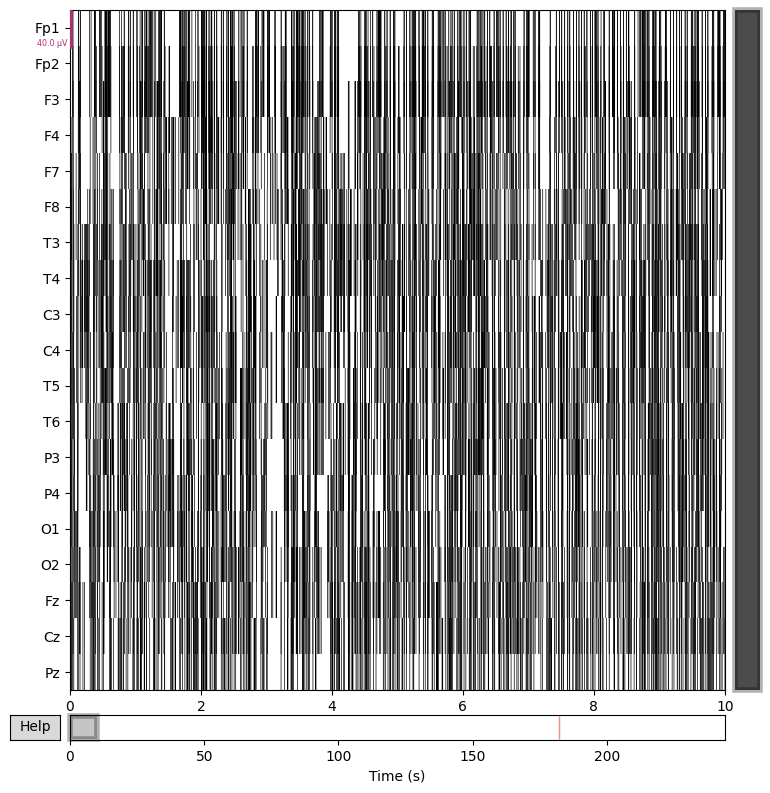

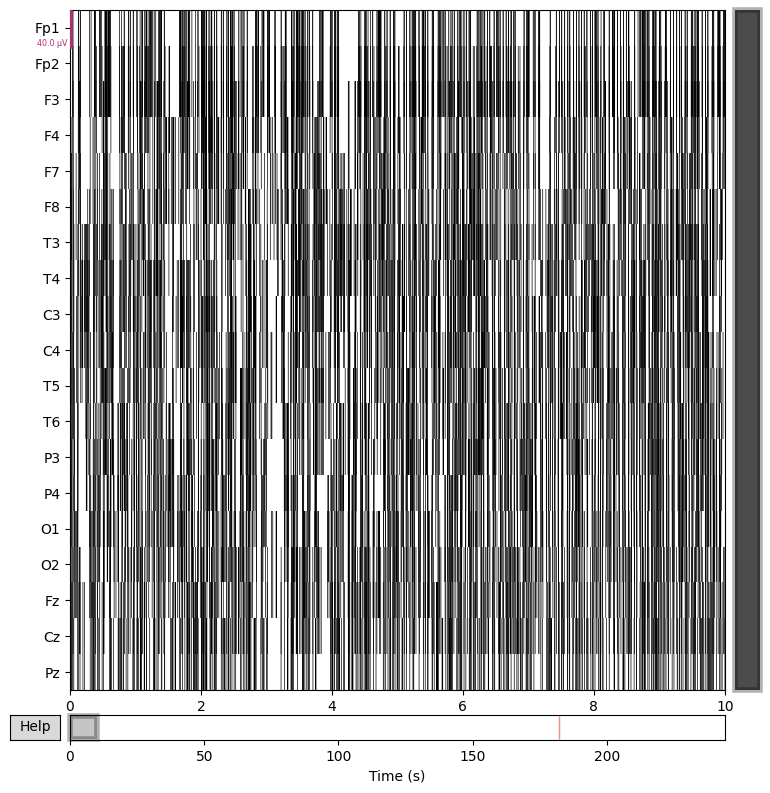

In [130]:
raw.plot()

c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\perez\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

<Axes: ylabel='Fp1'>

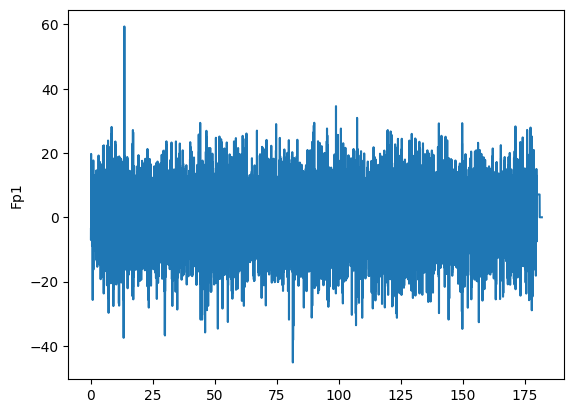

In [126]:
df_3 = np.transpose(df_1)
df_3.columns = CHANNELS

sns.lineplot(
    data=df_3, x=np.arange(0, 182, 2e-3), y='Fp1'
)